In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [ ]:
'''
function to check that tail_base was also inside arm for a list of nose frames
'''
def check_tail_entry(df_mouse_boolean, list_of_frames, ti):
    f=0; #tail entry frame, if valid
    fc=0;
    entered=False;
    for l in list_of_frames:
        if df_mouse_boolean.iloc[l,ti]==1:
            f=l;
            fc = fc+1;
        if fc>5:
            f = f-5;
            entered= True;
            break;
    return entered, f;

In [ ]:
'''
function to check when tail_base exited
'''
def check_tail_exit(df_mouse_boolean, startf, ti):
    xf=0; #tail entry frame, if valid
    fc=0;
    end= False;
    for l in range(startf, len(df_mouse_boolean)):
        if df_mouse_boolean.iloc[l,ti]==0:
            xf = l;
            fc = fc+1;
        else:
            fc=0;
        if fc>5:
            xf=l-5;
            break;
    return xf;

In [ ]:
'''
function to exclude repeat entries (when for a new nose entry, tail base is already inside arm)
'''
def check_repeat_entries(df_entries_stats_sorted):
    df_valid_entries_stats_sorted= df_entries_stats_sorted.drop_duplicates(subset=['Exit Frame'], keep='first')
    return df_valid_entries_stats_sorted;

In [ ]:
'''
main function will itirate through all frames for each nose inside arm X - from mouse_boolean.csv
then call function to validate if entry is valid (tail is also entered for more than 5 frames) - returns True
then once True, calculate entry latency - time for tail base to fully enter from nose sucessful entry
then from the moment tail enters calculate duration - until tail leave
calculate movement of nose and tail during the duration
then calculate exit latency - time for tail base to fully exit from nose sucessful exit

That will produce table as follows:
    entry frame    exit frame    duration   nose mov nose velocity  tail mov  tail velocity   entry latency   exit latency  nose entry frame  nose exit frame (both for later directionality purposes)  
A
A
A
B
B
C
C
D
D
E
E
E
'''
def valid_entries_stats(df_mouse_boolean, mouse_id):
    # 11 nose in A, 12 nose in B, ....
    entries = [];
    entry_frame=[];
    exit_frame=[];
    duration=[];
    entry_latency=[];
    exit_latency=[];
    nose_entry_frame=[];
    nose_exit_frame=[];

    for arm in range(11, 16):
        temp_ent = [];
        for frame in range(0, (len(df_mouse_boolean)-1)):
            if df_mouse_boolean.iloc[frame,arm]==1:
                temp_end = temp_ent.append(frame);
            else:
                if temp_ent: #if list is not empty
                    valid, tail_entry = check_tail_entry(df_mouse_boolean, temp_ent, arm+20);
                    if valid: # if tail_base is 1 for any
                        #check that it's not a subentry in an already recorded entry
                        #if exit_frame: # not the first entry 
                            #if df_mouse_boolean.iloc[temp_ent[0],arm+20]==0: #tail should not inside for new nose entry                  
                                if arm==11:
                                    entries.append('A');
                                elif arm==12:
                                    entries.append('B');
                                elif arm==13:
                                    entries.append('C');                        
                                elif arm==14:
                                    entries.append('D');
                                elif arm==15:
                                    entries.append('E');
                                    
                                entry_frame.append(tail_entry);
                                tail_exit = check_tail_exit(df_mouse_boolean, temp_ent[-1], arm+20);
                                exit_frame.append(tail_exit);
                                dur =  (tail_exit-tail_entry+1)/30; #duration in s
                                duration.append(dur);
                                nose_entry_frame.append(temp_ent[0]);
                                nose_exit_frame.append(temp_ent[-1]);
                                ent_lat = (tail_entry-temp_ent[0]+1)/30;
                                entry_latency.append(ent_lat);
                                exit_lat = (tail_exit-temp_ent[-1]+1)/30;
                                exit_latency.append(exit_lat);

        
                    temp_ent = []; #reset for next entry vals
        
    valid_entries_stats ={'Arm Entry':entries, 'Entry Frame':entry_frame, 'Exit Frame':exit_frame, 'Duration':duration, 
                          'Entry Latency':entry_latency, 'Exit Latency':exit_latency, 
                          'Nose Entry Frame':nose_entry_frame, 'Nose Exit Frame':nose_exit_frame}
    df_valid_entries_stats = pd.DataFrame(valid_entries_stats);
    df_valid_entries_stats.to_csv(mouse_id+'_entry_stats.csv');
    df_valid_entries_stats_s = df_valid_entries_stats.sort_values(by='Entry Frame');
    df_valid_entries_stats_sorted = check_repeat_entries(df_valid_entries_stats_s)
    df_valid_entries_stats_sorted = df_valid_entries_stats_sorted.reset_index(drop=True);
    df_valid_entries_stats_sorted.to_csv(mouse_id+'_entry_stats_sorted.csv');
    return df_valid_entries_stats, df_valid_entries_stats_sorted;

In [ ]:
'''
function just for the movement stats, 
entry frame and exit frame used for entry nose mov and vel and entry tail mov and vel
'''
def get_mov_stats(df_mouse_features, entry, exit, feature_i):
    total_mov=0;
    for m in df_mouse_features.iloc[entry:exit, feature_i]:
        total_mov = total_mov+ m;
    return total_mov;

In [ ]:
'''
function to get frames in between and give back a list of coefficients for each arm
'''
def get_coeff(df_features, start, end):
    a_count=0;
    b_count=0;
    c_count=0;
    d_count=0;
    e_count=0;
    none_count=0;
    for i in range(start, end+1):
        none=0
        if df_features.iloc[i, -5]:
            a_count=a_count+1;
        else:
            none=none+1;
        if df_features.iloc[i, -4]:
            b_count=b_count+1;
        else:
            none=none+1;
        if df_features.iloc[i, -3]:
            c_count=c_count+1;
        else:
            none=none+1;        
        if df_features.iloc[i, -2]:
            d_count=d_count+1;
        else:
            none=none+1;            
        if df_features.iloc[i, -1]:
            e_count=e_count+1;
        else:
            none=none+1;
        if none==5:
            none_count=none_count+1;
    tot = a_count+b_count+c_count+d_count+e_count+none_count;
    a_coeff = a_count/tot;
    b_coeff = b_count/tot;
    c_coeff = c_count/tot;
    d_coeff = d_count/tot;
    e_coeff = e_count/tot;
    return a_coeff, b_coeff, c_coeff, d_coeff, e_coeff;

In [ ]:
'''
this function will itirate through all entries in order of nose exit frame
call function to calculate time in the middle from nose exit to the next nose entry as duration in middle
calculate movement and velocity for that as well
and then call function to calculate directionality coefficients (from features csv) for those frames and return so that table is ordered as:

    time duration in middle before entry   mov middle velocity middle direct coeff A   direct coeff B   direct coeff C   direct coeff D   direct coeff E
A
B
D
E
C
A
D
B
E
'''
def all_other_stats(df_entries_sorted, df_mouse_features, mouse_id):
    entries = df_entries_sorted.iloc[:, 0]
    
    arm_nose_movement=[];
    arm_nose_velocity=[];
    arm_tail_movement=[];
    arm_tail_velocity=[];    

    middle_duration=[0]
    middle_nose_movement=[0];
    middle_nose_velocity=[0];
    middle_tail_movement=[0];
    middle_tail_velocity=[0];

    direct_coeff_A=[0];
    direct_coeff_B=[0];
    direct_coeff_C=[0];
    direct_coeff_D=[0];
    direct_coeff_E=[0];

    
    for ent_i in range(0, len(df_entries_sorted)):
        
        nose_arm_entry = df_entries_sorted.iloc[ent_i, 6];
        nose_arm_exit = df_entries_sorted.iloc[ent_i, 7];
        n_feature_i = df_mouse_features.columns.get_loc('Movement_mouse_nose');
        a_nose_mov = get_mov_stats(df_mouse_features, nose_arm_entry, nose_arm_exit, n_feature_i); 
        arm_nose_movement.append(a_nose_mov);
        a_nose_vel = a_nose_mov/df_entries_sorted.iloc[ent_i, 3]; #divide movement by the duration
        arm_nose_velocity.append(a_nose_vel);
        arm_entry = df_entries_sorted.iloc[ent_i, 1];
        arm_exit = df_entries_sorted.iloc[ent_i, 2];

        tail_arm_entry = df_entries_sorted.iloc[ent_i, 1];
        tail_arm_exit = df_entries_sorted.iloc[ent_i, 2];
        t_feature_i=df_mouse_features.columns.get_loc('Movement_mouse_tail_base');
        a_tail_mov = get_mov_stats(df_mouse_features, tail_arm_entry, tail_arm_exit, t_feature_i); 
        arm_tail_movement.append(a_tail_mov);
        a_tail_vel = a_tail_mov/df_entries_sorted.iloc[ent_i, 3]; #divide movement by the duration
        arm_tail_velocity.append(a_tail_vel);


        #now for all middle calculations, those always begin in ent2 (all the time between ent2 and ent1 - as video will always begin with mouse already in ent1)
        if ent_i!=0:
            n_start = df_entries_sorted.iloc[ent_i-1, 7];
            n_end = nose_arm_entry;
            m_n_dur = (n_end-n_start+1)/30
            
            m_nose_mov = get_mov_stats(df_mouse_features, n_start, n_end, n_feature_i);
            middle_nose_movement.append(m_nose_mov);
            m_nose_vel = m_nose_mov/m_n_dur;
            middle_nose_velocity.append(m_nose_vel);

            t_start = df_entries_sorted.iloc[ent_i-1, 2];
            t_end = tail_arm_entry;
            m_dur = (t_end-t_start+1)/30
            middle_duration.append(m_dur);
            
            m_tail_mov = get_mov_stats(df_mouse_features, t_start, t_end, t_feature_i);
            middle_tail_movement.append(m_tail_mov);
            m_tail_vel = m_tail_mov/m_dur;            
            middle_tail_velocity.append(m_tail_vel);

            ca, cb, cc, cd, ce = get_coeff(df_mouse_features, n_start, n_end);
            
            direct_coeff_A.append(ca);
            direct_coeff_B.append(cb);
            direct_coeff_C.append(cc);
            direct_coeff_D.append(cd);
            direct_coeff_E.append(ce);

    other_stats ={'Arm Entry':entries, 'Arm Nose Movement':arm_nose_movement, 'Arm Nose Velocity':arm_nose_velocity,
                  'Arm Tail Movement':arm_tail_movement, 'Arm Tail Velocity':arm_tail_velocity,'Middle Duration':middle_duration,
                  'Middle Nose Movement':middle_nose_movement, 'Middle Nose Velocity':middle_nose_velocity, 
                  'Middle Tail Movement':middle_tail_movement, 'Middle Tail Velocity':middle_tail_velocity, 
                  'Directionality Coefficiet A':direct_coeff_A, 'Directionality Coefficiet B':direct_coeff_B, 
                  'Directionality Coefficiet C':direct_coeff_C, 'Directionality Coefficiet D':direct_coeff_D, 
                  'Directionality Coefficiet E':direct_coeff_E}
    df_other_stats = pd.DataFrame(other_stats);
    df_other_stats = df_other_stats.reset_index(drop=True);
    df_other_stats.to_csv(mouse_id+'_other_stats.csv');
    return df_other_stats;


In [ ]:
'''
this function will just get the coefficients of the current arm entered and the past two so in ABC at C look at coeff for C and coeff for A
    current coeff  skip arm coeff   current coeff time proportional   skip arm coeff time proportional
A    value for A     value for none
B    value for B     value for none
C    value for C    value for A
D    value for D    value for B
E    value for E    value for C
A
C
'''

'''    
    for ent in range(1, len(df_other_stats)):
        ind=0;
        let = df_other_stats.iloc[ent,0];
        if let=='E':
            ind=-1
        elif let=='D':
            ind=-2
        elif let=='C':
            ind=-3
        elif let=='B':
            ind=-4
        elif let=='A':
            ind=-5
        
        if ent>=2:
            temp_c= df_other_stats.iloc[ent,ind];
            current_coeff.append(temp_c);

            temp_c_t = temp_c*df_other_stats.iloc[ent,5]; #coeff * time in middle
            current_coeff_time.append(temp_c_t);           
            lag_ind=0;
            lag_let = df_other_stats.iloc[ent-2,0];
            if lag_let=='E':
                lag_ind=-1
            elif lag_let=='D':
                lag_ind=-2
            elif lag_let=='C':
                lag_ind=-3
            elif lag_let=='B':
                lag_ind=-4
            elif lag_let=='A':
                lag_ind=-5
            
            temp_l= df_other_stats.iloc[ent,lag_ind];
            #lag_2_coeff.append(temp_l); 

            temp_l_t = temp_l*df_other_stats.iloc[ent,5]; #coeff * time in middle for current entry
            #lag_2_coeff_time.append(temp_l_t);
            
        else:
            temp_c= df_other_stats.iloc[ent,ind];
            current_coeff.append(temp_c);
            
            temp_c_t = temp_c*df_other_stats.iloc[ent,5]; #coeff * time in middle
            current_coeff_time.append(temp_c_t);

            lag_2_coeff.append(0);
            lag_2_coeff_time.append(0);
'''     
def add_lag_dir_coefficients(df_other_stats, mouse_id):
    entries = df_other_stats.iloc[:,0];
    
    cur_coeff=[];
    lag_1_cur_coeff=[0];
    lag_2_cur_coeff=[0,0];
    lag_3_cur_coeff=[0,0,0];
    lag_4_cur_coeff=[0,0,0,0];
    
    #lag_2_coeff=[0]; 
    
    cur_coeff_time=[];
    lag_1_cur_coeff_time=[0];
    lag_2_cur_coeff_time=[0,0];
    lag_3_cur_coeff_time=[0,0,0];
    lag_4_cur_coeff_time=[0,0,0,0];
    #lag_2_coeff_time=[0];

    for i in range(0, len(df_other_stats)):
        let = df_other_stats['Arm Entry'][i]
        if let=='E':
            ind=-1
        elif let=='D':
            ind=-2
        elif let=='C':
            ind=-3
        elif let=='B':
            ind=-4
        elif let=='A':
            ind=-5
            
        c = df_other_stats.iloc[i,ind]
        cur_coeff.append(c)
        tc = c*df_other_stats['Middle Duration'][i]
        cur_coeff_time.append(tc)
        
        if i > 3:
            c = df_other_stats.iloc[i-4,ind]
            lag_4_cur_coeff.append(c)
            tc = c*df_other_stats['Middle Duration'][i-4]
            lag_4_cur_coeff_time.append(tc)           
        if i > 2:
            c = df_other_stats.iloc[i-3,ind]
            lag_3_cur_coeff.append(c)
            tc = c*df_other_stats['Middle Duration'][i-3]
            lag_3_cur_coeff_time.append(tc)
        if i > 1:
            c = df_other_stats.iloc[i-2,ind]
            lag_2_cur_coeff.append(c)
            tc = c*df_other_stats['Middle Duration'][i-2]
            lag_2_cur_coeff_time.append(tc)
        if i > 0:
            c = df_other_stats.iloc[i-1,ind]
            lag_1_cur_coeff.append(c)
            tc = c*df_other_stats['Middle Duration'][i-1]
            lag_1_cur_coeff_time.append(tc)
            
        
    lagged_coeff ={'Arm Entry':entries, 'Current Coeff':cur_coeff, 'Lagged 1 Cur Coeff':lag_1_cur_coeff, 'Lagged 2 Cur Coeff':lag_2_cur_coeff,
                   'Lagged 3 Cur Coeff':lag_3_cur_coeff, 'Lagged 4 Cur Coeff':lag_4_cur_coeff,
                   'Current Coeff Time Proportional':cur_coeff_time, 'Lagged 1 Cur Coeff Time Proportional':lag_1_cur_coeff_time,
                   'Lagged 2 Cur Coeff Time Proportional':lag_2_cur_coeff_time, 'Lagged 3 Cur Coeff Time Proportional':lag_3_cur_coeff_time,
                   'Lagged 4 Cur Coeff Time Proportional':lag_4_cur_coeff_time
                  }
    

    df_lagged_coeff = pd.DataFrame(lagged_coeff);
    df_lagged_coeff = df_lagged_coeff.reset_index(drop=True);
    df_lagged_coeff.to_csv(mouse_id+'_lagged_coeff.csv');
    return df_lagged_coeff;

In [ ]:
def check_args(args):
    '''
    function checks whether list of arguments are unique
    returns boolean
    '''
    sequence=[];
    for arg in args:
        sequence.append(arg.lower());
    isunique = len(sequence)==len(set(sequence)) # set() removes repetitions
    return isunique #True for unique sequence, False if repetition

In [ ]:
'''
this function will be to return output
'''
def get_output(*args):
    for i in range(len(args)-1):
        output = len(args);
        if check_args(args[i:]):
            output = output-i;
            break;
        else:
            output = 1;
    return output;


In [ ]:
'''
this function will set ouput as the choice level (5,4,3,2, and 1)
A   1      
B   2 
D   3
E   4
C   5
A   5
D   4
B   5
E   5
and will finally create all info needed for the next step - classifier
'''
def add_choice_output(df_entry_stats_ordered, df_other_stats, df_lagged_coeff, mouse_id):
    
    entries = df_entry_stats_ordered.iloc[:,0];
    '''
    duration = df_entry_stats_ordered.iloc[:,3];
    entry_latency = df_entry_stats_ordered.iloc[:,4];
    exit_latency = df_entry_stats_ordered.iloc[:,5];
    arm_nose_movement = df_other_stats.iloc[:,1];
    arm_nose_velocity = df_other_stats.iloc[:,2];
    arm_tail_movement = df_other_stats.iloc[:,3];
    arm_tail_velocity = df_other_stats.iloc[:,4];
    middle_duration = df_other_stats.iloc[:,5];
    middle_nose_movement = df_other_stats.iloc[:,6];
    middle_nose_velocity = df_other_stats.iloc[:,7];
    middle_tail_movement = df_other_stats.iloc[:,8];
    middle_tail_velocity = df_other_stats.iloc[:,9];
    current_coeff = df_lagged_coeff.iloc[:, 1];
    lagged_2_coeff = df_lagged_coeff.iloc[:, 2];
    current_coeff_time = df_lagged_coeff.iloc[:, 3];
    lagged_2_coeff_time = df_lagged_coeff.iloc[:, 4];
    '''

    choice_output=[1];
   
    p_exitmid_1 = [0]
    p_midentry_1 = [0]
    p_exitmidentry_1 = [0]
   
    for ind in range(1, len(entries)):

        p_exitmid_1.append(np.sum([df_entry_stats_ordered['Exit Latency'][ind-1],df_other_stats['Middle Duration'][ind]])); 
        p_midentry_1.append(np.sum([df_other_stats['Middle Duration'][ind], df_entry_stats_ordered['Entry Latency'][ind]]));
        p_exitmidentry_1.append(np.sum([df_entry_stats_ordered['Exit Latency'][ind-1],df_other_stats['Middle Duration'][ind], df_entry_stats_ordered['Entry Latency'][ind]]));
        
        ent1 = df_entry_stats_ordered.iloc[ind-4,0]
        ent2 = df_entry_stats_ordered.iloc[ind-3,0]
        ent3 = df_entry_stats_ordered.iloc[ind-2,0]
        ent4 = df_entry_stats_ordered.iloc[ind-1,0]
        ent5 = df_entry_stats_ordered.iloc[ind,0]

        if ind > 3:
            temp_output = get_output(ent1, ent2, ent3, ent4, ent5)
            choice_output.append(temp_output);
        elif ind > 2:
            temp_output = get_output(ent2, ent3, ent4, ent5)
            choice_output.append(temp_output);        
        elif ind >1:
            temp_output = get_output(ent3, ent4, ent5)
            choice_output.append(temp_output);
        elif ind >0:
            temp_output = get_output(ent4, ent5)
            choice_output.append(temp_output);
    '''
    everything_stats ={'Arm Entry':entries, 'Duration':duration, 'Entry Latency':entry_latency, 'Exit Latency':exit_latency,
                       'Arm Nose Movement':arm_nose_movement, 'Arm Nose Velocity':arm_nose_velocity,
                  'Arm Tail Movement':arm_tail_movement, 'Arm Tail Velocity':arm_tail_velocity,'Middle Duration':middle_duration,
                  'Middle Nose Movement':middle_nose_movement, 'Middle Nose Velocity':middle_nose_velocity, 
                  'Middle Tail Movement':middle_tail_movement, 'Middle Tail Velocity':middle_tail_velocity, 
                  'Current Coeff':current_coeff, 'Lagged 2 Coeff':lagged_2_coeff, 
                  'Current Coeff Time Proportional':current_coeff_time, 'Lagged 2 Time Proportional':lagged_2_coeff_time, 'Choice Output':choice_output}
    
    len(entries)
    len(choice_output)
    len(everything_stats)

    
    everything_stats = pd.DataFrame(everything_stats);
    df_everything_stats = df_everything_stats.reset_index(drop=True);
    df_everything_stats.to_csv(mouse_id+'_everything_stats.csv');
   '''
    
    
    df_everything_stats = df_entry_stats_ordered.drop(columns = ['Entry Frame', 'Exit Frame', 'Nose Entry Frame', 'Nose Exit Frame'])
    df_everything_stats['Arm Nose Movement'] = df_other_stats['Arm Nose Movement']
    df_everything_stats['Arm Nose Velocity'] = df_other_stats['Arm Nose Velocity']
    df_everything_stats['Arm Tail Movement'] = df_other_stats['Arm Tail Movement']
    df_everything_stats['Arm Tail Velocity'] = df_other_stats['Arm Tail Velocity']
                                                                 
    df_everything_stats['Middle Duration'] = df_other_stats['Middle Duration']
    df_everything_stats['Middle Nose Movement'] = df_other_stats['Middle Nose Movement']
    df_everything_stats['Middle Nose Velocity'] = df_other_stats['Middle Nose Velocity']
    df_everything_stats['Middle Tail Movement'] = df_other_stats['Middle Tail Movement']
    df_everything_stats['Middle Tail Velocity'] = df_other_stats['Middle Tail Velocity']

    df_everything_stats['ExitMid Duration'] = p_exitmid_1
    df_everything_stats['MidEntry Duration'] = p_midentry_1
    df_everything_stats['ExitMidEntry Duration'] = p_exitmidentry_1

    df_everything_stats['ExitMidEntry Duration'] = p_exitmidentry_1
    df_everything_stats['ExitMidEntry Duration'] = p_exitmidentry_1
    df_everything_stats['ExitMidEntry Duration'] = p_exitmidentry_1
    df_everything_stats['ExitMidEntry Duration'] = p_exitmidentry_1
    
    df_everything_stats['Current Coeff'] = df_lagged_coeff['Current Coeff']
    df_everything_stats['Lagged 1 Cur Coeff'] = df_lagged_coeff['Lagged 1 Cur Coeff']
    df_everything_stats['Lagged 2 Cur Coeff'] = df_lagged_coeff['Lagged 2 Cur Coeff']
    df_everything_stats['Lagged 3 Cur Coeff'] = df_lagged_coeff['Lagged 3 Cur Coeff']
    df_everything_stats['Lagged 4 Cur Coeff'] = df_lagged_coeff['Lagged 4 Cur Coeff']

    df_everything_stats['Current Coeff Time Proportional'] = df_lagged_coeff['Current Coeff Time Proportional']
    df_everything_stats['Lagged 1 Cur Coeff Time Proportional'] = df_lagged_coeff['Lagged 1 Cur Coeff Time Proportional']
    df_everything_stats['Lagged 2 Cur Coeff Time Proportional'] = df_lagged_coeff['Lagged 2 Cur Coeff Time Proportional']
    df_everything_stats['Lagged 3 Cur Coeff Time Proportional'] = df_lagged_coeff['Lagged 3 Cur Coeff Time Proportional']
    df_everything_stats['Lagged 4 Cur Coeff Time Proportional'] = df_lagged_coeff['Lagged 4 Cur Coeff Time Proportional']

    df_everything_stats['Choice Output'] = choice_output
    df_everything_stats = df_everything_stats.reset_index(drop=True);    
    df_everything_stats.to_csv(mouse_id+'_everything_stats.csv');

    return df_everything_stats;


In [94]:
'''
function to create the lagging for all previous 4 choices
'''
def lagging_four_prev_choices(df_pls):
    lagged_df_everything_stats = df_pls.select(
    "Duration", 
    *[pl.col("Duration").shift(i).alias(f"lagged_{i}_duration") for i in [1,2,3,4]],
    "Entry Latency", 
    *[pl.col("Entry Latency").shift(i).alias(f"lagged_{i}_entry_lat") for i in [1,2,3,4]],
    "Exit Latency", 
    *[pl.col("Exit Latency").shift(i).alias(f"lagged_{i}_exit_lat") for i in [1,2,3,4]], 
    "Arm Nose Movement", 
    *[pl.col("Arm Nose Movement").shift(i).alias(f"lagged_{i}_arm_nose_mov") for i in [1,2,3,4]],
    "Arm Nose Velocity", 
    *[pl.col("Arm Nose Velocity").shift(i).alias(f"lagged_{i}_arm_nose_vel") for i in [1,2,3,4]],
    "Arm Tail Movement", 
    *[pl.col("Arm Tail Movement").shift(i).alias(f"lagged_{i}_arm_tail_mov") for i in [1,2,3,4]],
    "Arm Tail Velocity", 
    *[pl.col("Arm Tail Velocity").shift(i).alias(f"lagged_{i}_arm_tail_vel") for i in [1,2,3,4]],
    "Middle Duration", 
    *[pl.col("Middle Duration").shift(i).alias(f"lagged_{i}_mid_duration") for i in [1,2,3,4]],
    "Middle Nose Movement", 
    *[pl.col("Middle Nose Movement").shift(i).alias(f"lagged_{i}_mid_nose_mov") for i in [1,2,3,4]],
    "Middle Nose Velocity", 
    *[pl.col("Middle Nose Velocity").shift(i).alias(f"lagged_{i}_mid_nose_vel") for i in [1,2,3,4]],
    "Middle Tail Movement", 
    *[pl.col("Middle Tail Movement").shift(i).alias(f"lagged_{i}_mid_tail_mov") for i in [1,2,3,4]],
    "Middle Tail Velocity", 
    *[pl.col("Middle Tail Velocity").shift(i).alias(f"lagged_{i}_mid_tail_vel") for i in [1,2,3,4]],

    "ExitMid Duration",
    *[pl.col("ExitMid Duration").shift(i).alias(f"lagged_{i}_exitmid_duration") for i in [1,2,3,4]],
    "MidEntry Duration", 
    *[pl.col("MidEntry Duration").shift(i).alias(f"lagged_{i}_midentry_duration") for i in [1,2,3,4]],
    "ExitMidEntry Duration",
    *[pl.col("ExitMidEntry Duration").shift(i).alias(f"lagged_{i}_exitmidentry_duration") for i in [1,2,3,4]],
    
    "Current Coeff", 
    *[pl.col("Current Coeff").shift(i).alias(f"lagged_{i}_current_coeff") for i in [1,2,3,4]],

    
    "Lagged 1 Cur Coeff", 
    *[pl.col("Lagged 1 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_1_cur_coeff") for i in [1,2,3,4]],
    "Lagged 2 Cur Coeff", 
    *[pl.col("Lagged 2 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_2_cur_coeff") for i in [1,2,3,4]],
    "Lagged 3 Cur Coeff", 
    *[pl.col("Lagged 3 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_3_cur_coeff") for i in [1,2,3,4]],
    "Lagged 4 Cur Coeff", 
    *[pl.col("Lagged 4 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_4_cur_coeff") for i in [1,2,3,4]],

    
    "Current Coeff Time Proportional", 
    *[pl.col("Current Coeff Time Proportional").shift(i).alias(f"lagged_{i}_current_coeff_time_prop") for i in [1,2,3,4]],

    "Lagged 1 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 1 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_1_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 2 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 2 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_2_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 3 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 3 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_3_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 4 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 4 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_4_cur_coeff_time_prop") for i in [1,2,3,4]],
    
    "Choice Output", 
    *[pl.col("Choice Output").shift(i).alias(f"lagged_{i}_choice_ago") for i in [1,2,3,4]]
    )
    lagged_df_everything_stats = lagged_df_everything_stats.drop_nulls()
    return lagged_df_everything_stats;

In [95]:
def added_time_means(lagged_df_everything_stats, mouse_id):
    f = lagged_df_everything_stats.drop(columns = ['Choice Output', 'lagged_1_choice_ago', 'lagged_2_choice_ago','lagged_3_choice_ago', 
                                                   'lagged_4_choice_ago']);
    r_arm_mean2s = []
    r_arm_mean3s = []
    r_arm_mean4s = []
    r_arm_mean5s = []

    p_arm_mean2s = []
    p_arm_mean3s = []
    p_arm_mean4s = []

    p_mid_mean2s = []
    p_mid_mean3s = []
    p_mid_mean4s = []
    p_mid_mean5s = []

    r_arm_2s = []
    r_arm_3s = []
    r_arm_4s = []
    r_arm_5s = []

    p_arm_2s = []
    p_arm_3s = []
    p_arm_4s = []

    p_mid_2s = []
    p_mid_3s = []
    p_mid_4s = []
    p_mid_5s = []
    
    p_exitmid_2s = []
    p_exitmid_3s = []
    p_exitmid_4s = []
    p_exitmid_5s = []

    p_exitmid_mean2s = []
    p_exitmid_mean3s = []
    p_exitmid_mean4s = []
    p_exitmid_mean5s = []

    p_midentry_2s = []
    p_midentry_3s = []
    p_midentry_4s = []
    p_midentry_5s = []

    p_midentry_mean2s = []
    p_midentry_mean3s = []
    p_midentry_mean4s = []
    p_midentry_mean5s = []
    
    p_exitmidentry_2s = []
    p_exitmidentry_3s = []
    p_exitmidentry_4s = []
    p_exitmidentry_5s = []

    p_exitmidentry_mean2s = []
    p_exitmidentry_mean3s = []
    p_exitmidentry_mean4s = []
    p_exitmidentry_mean5s = []

    
    for i in range(0, len(lagged_df_everything_stats)):
        r_arm_2s.append(np.sum([f['Duration'][i], f['lagged_1_duration'][i]]));
        r_arm_3s.append(np.sum([f['Duration'][i], f['lagged_1_duration'][i], f['lagged_2_duration'][i]]));
        r_arm_4s.append(np.sum([f['Duration'][i], f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i]]));
        r_arm_5s.append(np.sum([f['Duration'][i], f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i], f['lagged_4_duration'][i]]));        
        
        r_arm_mean2s.append(np.average([f['Duration'][i], f['lagged_1_duration'][i]]));
        r_arm_mean3s.append(np.average([f['Duration'][i], f['lagged_1_duration'][i], f['lagged_2_duration'][i]]));
        r_arm_mean4s.append(np.average([f['Duration'][i], f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i]]));
        r_arm_mean5s.append(np.average([f['Duration'][i], f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i], f['lagged_4_duration'][i]]));

        p_arm_2s.append(np.sum([f['lagged_1_duration'][i], f['lagged_2_duration'][i]]));
        p_arm_3s.append(np.sum([f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i]]));
        p_arm_4s.append(np.sum([f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i], f['lagged_4_duration'][i]]));
        
        p_arm_mean2s.append(np.average([f['lagged_1_duration'][i], f['lagged_2_duration'][i]]));
        p_arm_mean3s.append(np.average([f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i]]));
        p_arm_mean4s.append(np.average([f['lagged_1_duration'][i], f['lagged_2_duration'][i], f['lagged_3_duration'][i], f['lagged_4_duration'][i]]));
       
        p_mid_2s.append(np.sum([f['Middle Duration'][i], f['lagged_1_mid_duration'][i]]));
        p_mid_3s.append(np.sum([f['Middle Duration'][i], f['lagged_1_mid_duration'][i], f['lagged_2_mid_duration'][i]]));
        p_mid_4s.append(np.sum([f['Middle Duration'][i], f['lagged_1_mid_duration'][i], f['lagged_2_mid_duration'][i], f['lagged_3_mid_duration'][i]]));
        p_mid_5s.append(np.sum([f['Middle Duration'][i], f['lagged_1_mid_duration'][i], f['lagged_2_mid_duration'][i], f['lagged_3_mid_duration'][i], f['lagged_4_mid_duration'][i]]));
        
        p_mid_mean2s.append(np.average([f['Middle Duration'][i], f['lagged_1_mid_duration'][i]]));
        p_mid_mean3s.append(np.average([f['Middle Duration'][i], f['lagged_1_mid_duration'][i], f['lagged_2_mid_duration'][i]]));
        p_mid_mean4s.append(np.average([f['Middle Duration'][i], f['lagged_1_mid_duration'][i], f['lagged_2_mid_duration'][i], f['lagged_3_mid_duration'][i]]));
        p_mid_mean5s.append(np.average([f['Middle Duration'][i], f['lagged_1_mid_duration'][i], f['lagged_2_mid_duration'][i], f['lagged_3_mid_duration'][i], f['lagged_4_mid_duration'][i]]));

        p_exitmid_2s.append(np.sum([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i]]));
        p_exitmid_3s.append(np.sum([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i], f['lagged_2_exitmid_duration'][i]]));
        p_exitmid_4s.append(np.sum([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i], f['lagged_2_exitmid_duration'][i], f['lagged_3_exitmid_duration'][i]]));
        p_exitmid_5s.append(np.sum([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i], f['lagged_2_exitmid_duration'][i], f['lagged_3_exitmid_duration'][i], f['lagged_4_exitmid_duration'][i]]));
        
        p_exitmid_mean2s.append(np.average([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i]]));
        p_exitmid_mean3s.append(np.average([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i], f['lagged_2_exitmid_duration'][i]]));
        p_exitmid_mean4s.append(np.average([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i], f['lagged_2_exitmid_duration'][i], f['lagged_3_exitmid_duration'][i]]));
        p_exitmid_mean5s.append(np.average([f['ExitMid Duration'][i], f['lagged_1_exitmid_duration'][i], f['lagged_2_exitmid_duration'][i], f['lagged_3_exitmid_duration'][i], f['lagged_4_exitmid_duration'][i]]));

        p_midentry_2s.append(np.sum([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i]]));
        p_midentry_3s.append(np.sum([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i], f['lagged_2_midentry_duration'][i]]));
        p_midentry_4s.append(np.sum([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i], f['lagged_2_midentry_duration'][i], f['lagged_3_midentry_duration'][i]]));
        p_midentry_5s.append(np.sum([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i], f['lagged_2_midentry_duration'][i], f['lagged_3_midentry_duration'][i], f['lagged_4_midentry_duration'][i]]));

        p_midentry_mean2s.append(np.average([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i]]));
        p_midentry_mean3s.append(np.average([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i], f['lagged_2_midentry_duration'][i]]));
        p_midentry_mean4s.append(np.average([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i], f['lagged_2_midentry_duration'][i], f['lagged_3_midentry_duration'][i]]));
        p_midentry_mean5s.append(np.average([f['MidEntry Duration'][i], f['lagged_1_midentry_duration'][i], f['lagged_2_midentry_duration'][i], f['lagged_3_midentry_duration'][i], f['lagged_4_midentry_duration'][i]]));
        
        p_exitmidentry_2s.append(np.sum([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i]]));
        p_exitmidentry_3s.append(np.sum([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i], f['lagged_2_exitmidentry_duration'][i]]));
        p_exitmidentry_4s.append(np.sum([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i], f['lagged_2_exitmidentry_duration'][i], f['lagged_3_exitmidentry_duration'][i]]));
        p_exitmidentry_5s.append(np.sum([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i], f['lagged_2_exitmidentry_duration'][i], f['lagged_3_exitmidentry_duration'][i], f['lagged_4_exitmidentry_duration'][i]]));
        
        p_exitmidentry_mean2s.append(np.average([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i]]));
        p_exitmidentry_mean3s.append(np.average([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i], f['lagged_2_exitmidentry_duration'][i]]));
        p_exitmidentry_mean4s.append(np.average([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i], f['lagged_2_exitmidentry_duration'][i], f['lagged_3_exitmidentry_duration'][i]]));
        p_exitmidentry_mean5s.append(np.average([f['ExitMidEntry Duration'][i], f['lagged_1_exitmidentry_duration'][i], f['lagged_2_exitmidentry_duration'][i], f['lagged_3_exitmidentry_duration'][i], f['lagged_4_exitmidentry_duration'][i]]));
               

    
    f['2_cur_arm_duration'] = r_arm_2s;
    f['3_cur_arm_duration'] = r_arm_3s;
    f['4_cur_arm_duration'] = r_arm_4s;
    f['5_cur_arm_duration'] = r_arm_5s;        

    f['mean_2_cur_arm_duration'] = r_arm_mean2s;
    f['mean_3_cur_arm_duration'] = r_arm_mean3s;
    f['mean_4_cur_arm_duration'] = r_arm_mean4s;
    f['mean_5_cur_arm_duration'] = r_arm_mean5s;

    f['2_past_arm_duration'] = p_arm_2s;
    f['3_past_arm_duration'] = p_arm_3s;
    f['4_past_arm_duration'] = p_arm_4s;
    
    f['mean_2_past_arm_duration'] = p_arm_mean2s;
    f['mean_3_past_arm_duration'] = p_arm_mean3s;
    f['mean_4_past_arm_duration'] = p_arm_mean4s;

    f['2_past_mid_duration'] = p_mid_2s;
    f['3_past_mid_duration'] = p_mid_3s;
    f['4_past_mid_duration'] = p_mid_4s;
    f['5_past_mid_duration'] = p_mid_5s;
    
    f['mean_2_past_mid_duration'] = p_mid_mean2s;
    f['mean_3_past_mid_duration'] = p_mid_mean3s;
    f['mean_4_past_mid_duration'] = p_mid_mean4s;
    f['mean_5_past_mid_duration'] = p_mid_mean5s;


    f['2_past_exitmid_duration'] = p_exitmid_2s;
    f['3_past_exitmid_duration'] = p_exitmid_3s;
    f['4_past_exitmid_duration'] = p_exitmid_4s;
    f['5_past_exitmid_duration'] = p_exitmid_5s;
    
    f['mean_2_past_exitmid_duration'] = p_exitmid_mean2s;
    f['mean_3_past_exitmid_duration'] = p_exitmid_mean3s;
    f['mean_4_past_exitmid_duration'] = p_exitmid_mean4s;
    f['mean_5_past_exitmid_duration'] = p_exitmid_mean5s;

    f['2_past_midentry_duration'] = p_midentry_2s;
    f['3_past_midentry_duration'] = p_midentry_3s;
    f['4_past_midentry_duration'] = p_midentry_4s;
    f['5_past_midentry_duration'] = p_midentry_5s;
    
    f['mean_2_past_midentry_duration'] = p_midentry_mean2s;
    f['mean_3_past_midentry_duration'] = p_midentry_mean3s;
    f['mean_4_past_midentry_duration'] = p_midentry_mean4s;
    f['mean_5_past_midentry_duration'] = p_midentry_mean5s;

    f['2_past_exitmidentry_duration'] = p_exitmidentry_2s;
    f['3_past_exitmidentry_duration'] = p_exitmidentry_3s;
    f['4_past_exitmidentry_duration'] = p_exitmidentry_4s;
    f['5_past_exitmidentry_duration'] = p_exitmidentry_5s;
    
    f['mean_2_past_exitmidentry_duration'] = p_exitmidentry_mean2s;
    f['mean_3_past_exitmidentry_duration'] = p_exitmidentry_mean3s;
    f['mean_4_past_exitmidentry_duration'] = p_exitmidentry_mean4s;
    f['mean_5_past_exitmidentry_duration'] = p_exitmidentry_mean5s;

    f['Choice Output'] = lagged_df_everything_stats['Choice Output']
    f['lagged_1_choice_ago'] = lagged_df_everything_stats['lagged_1_choice_ago']
    f['lagged_2_choice_ago'] = lagged_df_everything_stats['lagged_2_choice_ago']
    f['lagged_3_choice_ago'] = lagged_df_everything_stats['lagged_3_choice_ago']
    f['lagged_4_choice_ago'] = lagged_df_everything_stats['lagged_4_choice_ago']

    
    df_added_stats = pd.DataFrame(f);
    df_added_stats = df_added_stats.reset_index(drop=True);
    df_added_stats.to_csv(mouse_id+'_added_stats.csv');
    return df_added_stats;

In [96]:
'''
function to create the lagging for all previous 4 choices
'''
def lagging_four_prev_choices(df_pls):
    lagged_df_everything_stats = df_pls.select(
    "Duration", 
    *[pl.col("Duration").shift(i).alias(f"lagged_{i}_duration") for i in [1,2,3,4]],
    "Entry Latency", 
    *[pl.col("Entry Latency").shift(i).alias(f"lagged_{i}_entry_lat") for i in [1,2,3,4]],
    "Exit Latency", 
    *[pl.col("Exit Latency").shift(i).alias(f"lagged_{i}_exit_lat") for i in [1,2,3,4]], 
    "Arm Nose Movement", 
    *[pl.col("Arm Nose Movement").shift(i).alias(f"lagged_{i}_arm_nose_mov") for i in [1,2,3,4]],
    "Arm Nose Velocity", 
    *[pl.col("Arm Nose Velocity").shift(i).alias(f"lagged_{i}_arm_nose_vel") for i in [1,2,3,4]],
    "Arm Tail Movement", 
    *[pl.col("Arm Tail Movement").shift(i).alias(f"lagged_{i}_arm_tail_mov") for i in [1,2,3,4]],
    "Arm Tail Velocity", 
    *[pl.col("Arm Tail Velocity").shift(i).alias(f"lagged_{i}_arm_tail_vel") for i in [1,2,3,4]],
    "Middle Duration", 
    *[pl.col("Middle Duration").shift(i).alias(f"lagged_{i}_mid_duration") for i in [1,2,3,4]],
    "Middle Nose Movement", 
    *[pl.col("Middle Nose Movement").shift(i).alias(f"lagged_{i}_mid_nose_mov") for i in [1,2,3,4]],
    "Middle Nose Velocity", 
    *[pl.col("Middle Nose Velocity").shift(i).alias(f"lagged_{i}_mid_nose_vel") for i in [1,2,3,4]],
    "Middle Tail Movement", 
    *[pl.col("Middle Tail Movement").shift(i).alias(f"lagged_{i}_mid_tail_mov") for i in [1,2,3,4]],
    "Middle Tail Velocity", 
    *[pl.col("Middle Tail Velocity").shift(i).alias(f"lagged_{i}_mid_tail_vel") for i in [1,2,3,4]],

    "ExitMid Duration",
    *[pl.col("ExitMid Duration").shift(i).alias(f"lagged_{i}_exitmid_duration") for i in [1,2,3,4]],
    "MidEntry Duration", 
    *[pl.col("MidEntry Duration").shift(i).alias(f"lagged_{i}_midentry_duration") for i in [1,2,3,4]],
    "ExitMidEntry Duration",
    *[pl.col("ExitMidEntry Duration").shift(i).alias(f"lagged_{i}_exitmidentry_duration") for i in [1,2,3,4]],
    
    "Current Coeff", 
    *[pl.col("Current Coeff").shift(i).alias(f"lagged_{i}_current_coeff") for i in [1,2,3,4]],

    
    "Lagged 1 Cur Coeff", 
    *[pl.col("Lagged 1 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_1_cur_coeff") for i in [1,2,3,4]],
    "Lagged 2 Cur Coeff", 
    *[pl.col("Lagged 2 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_2_cur_coeff") for i in [1,2,3,4]],
    "Lagged 3 Cur Coeff", 
    *[pl.col("Lagged 3 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_3_cur_coeff") for i in [1,2,3,4]],
    "Lagged 4 Cur Coeff", 
    *[pl.col("Lagged 4 Cur Coeff").shift(i).alias(f"lagged_{i}_lagged_4_cur_coeff") for i in [1,2,3,4]],

    
    "Current Coeff Time Proportional", 
    *[pl.col("Current Coeff Time Proportional").shift(i).alias(f"lagged_{i}_current_coeff_time_prop") for i in [1,2,3,4]],

    "Lagged 1 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 1 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_1_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 2 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 2 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_2_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 3 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 3 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_3_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 4 Cur Coeff Time Proportional", 
    *[pl.col("Lagged 4 Cur Coeff Time Proportional").shift(i).alias(f"lagged_{i}_lagged_4_cur_coeff_time_prop") for i in [1,2,3,4]],
    
    "Choice Output", 
    *[pl.col("Choice Output").shift(i).alias(f"lagged_{i}_choice_ago") for i in [1,2,3,4]]
    )
    lagged_df_everything_stats = lagged_df_everything_stats.drop_nulls()
    return lagged_df_everything_stats;


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# non-scaled full

In [150]:
df_added_stats_sa199m2e = pd.read_csv('df_added_stats_sa199m2e.csv')
df_added_stats_sa196m2e = pd.read_csv('df_added_stats_sa196m2e.csv')
df_added_stats_sa196m1e = pd.read_csv('df_added_stats_sa196m1e.csv')
df_added_stats_sa198m2e = pd.read_csv('df_added_stats_sa198m2e.csv')
df_added_stats_sa196m3e = pd.read_csv('df_added_stats_sa196m3e.csv')
df_added_stats_sa199m3e = pd.read_csv('df_added_stats_sa199m3e.csv')
df_added_stats_sa199m1e = pd.read_csv('df_added_stats_sa199m1e.csv')
df_added_stats_sa78m1 = pd.read_csv('df_added_stats_sa78m1.csv')
df_added_stats_sa78m3 = pd.read_csv('df_added_stats_sa78m3.csv')
df_added_stats_sa78m5 = pd.read_csv('df_added_stats_sa78m5.csv')

In [151]:
group_unscaled = pd.concat([df_added_stats_sa199m2e, df_added_stats_sa196m2e, df_added_stats_sa196m1e, df_added_stats_sa198m2e,
                           df_added_stats_sa196m3e, df_added_stats_sa196m3e, df_added_stats_sa199m3e, df_added_stats_sa199m1e,
                            df_added_stats_sa78m1, df_added_stats_sa78m3, df_added_stats_sa78m5])

In [152]:
group_unscaled.head()

,Unnamed: 0,Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,...,5_past_exitmidentry_duration,mean_2_past_exitmidentry_duration,mean_3_past_exitmidentry_duration,mean_4_past_exitmidentry_duration,mean_5_past_exitmidentry_duration,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
0,0,3.666667,3.633333,3.600000,5.200000,5.566667,0.333333,0.466667,0.466667,0.566667,...,6.833333,1.600000,1.733333,1.708333,1.366667,3,4,3,2,1
1,1,2.833333,3.666667,3.633333,3.600000,5.200000,0.366667,0.333333,0.466667,0.466667,...,8.333333,1.516667,1.566667,1.675000,1.666667,3,3,4,3,2
2,2,3.500000,2.833333,3.666667,3.633333,3.600000,0.566667,0.366667,0.333333,0.466667,...,8.533333,1.666667,1.622222,1.633333,1.706667,4,3,3,4,3
3,3,3.266667,3.500000,2.833333,3.666667,3.633333,0.533333,0.566667,0.366667,0.333333,...,8.166667,1.733333,1.655556,1.625000,1.633333,3,4,3,3,4
4,4,2.866667,3.266667,3.500000,2.833333,3.666667,1.066667,0.533333,0.566667,0.366667,...,9.200000,2.166667,2.055556,1.916667,1.840000,3,3,4,3,3


In [153]:
group_unscaled = group_unscaled.reset_index(drop=True)

In [154]:
x_unscaled = group_unscaled.iloc[:,1:][group_unscaled['Choice Output'] > 1].drop(columns = ['Choice Output']).values

In [155]:
y_unscaled = group_unscaled[group_unscaled['Choice Output'] > 1]['Choice Output'].values

In [156]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(x_unscaled, y_unscaled, test_size=0.2, random_state=42)

In [157]:
modu = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.05)
modu.fit(X_train_u, y_train_u)
# make a single prediction
y_pred_u = modu.predict(X_test_u)

In [158]:
print(f1_score(y_test_u, y_pred_u, average = 'weighted'))

0.6141608391608391


In [159]:
print(precision_score(y_test_u, y_pred_u,average='weighted'))

0.6541666666666667


In [160]:
cf_matrixu = confusion_matrix(y_test_u, y_pred_u)

In [161]:
cf_matrixu

array([[ 5,  4,  4,  0],
       [ 1, 21,  0,  0],
       [ 7,  6, 16,  3],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

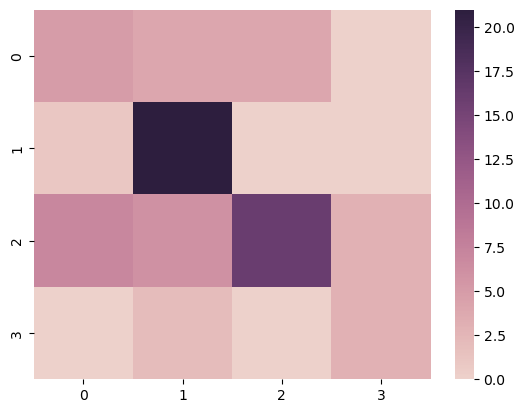

In [162]:
sns.heatmap(data = cf_matrixu, cmap=sns.cubehelix_palette(as_cmap=True))

# scaled (before lagging) full

In [188]:
minmaxsc = MinMaxScaler(feature_range=(0.01, 1), copy=True, clip=False)

In [189]:
df_everything_stats_sa199m2e = pd.read_csv('sa199m2e_everything_stats.csv')
df_everything_stats_sa196m2e = pd.read_csv('sa196m2e_everything_stats.csv')
df_everything_stats_sa196m1e = pd.read_csv('sa196m1e_everything_stats.csv')
df_everything_stats_sa198m2e = pd.read_csv('sa198m2e_everything_stats.csv')
df_everything_stats_sa196m3e = pd.read_csv('sa196m3e_everything_stats.csv')
df_everything_stats_sa199m3e = pd.read_csv('sa199m3e_everything_stats.csv')
df_everything_stats_sa199m1e = pd.read_csv('sa199m1e_everything_stats.csv')
df_everything_stats_sa78m1 = pd.read_csv('sa78m1_everything_stats.csv')
df_everything_stats_sa78m3 = pd.read_csv('sa78m3_everything_stats.csv')
df_everything_stats_sa78m5 = pd.read_csv('sa78m5_everything_stats.csv')

In [190]:
mm_everything_stats_sa199m2e = df_everything_stats_sa199m2e.copy()
mm_everything_stats_sa196m2e = df_everything_stats_sa196m2e.copy()
mm_everything_stats_sa196m1e = df_everything_stats_sa196m1e.copy()
mm_everything_stats_sa198m2e = df_everything_stats_sa198m2e.copy()
mm_everything_stats_sa196m3e = df_everything_stats_sa196m3e.copy()
mm_everything_stats_sa199m3e = df_everything_stats_sa199m3e.copy()
mm_everything_stats_sa199m1e = df_everything_stats_sa199m1e.copy()
mm_everything_stats_sa78m1 = df_everything_stats_sa78m1.copy()
mm_everything_stats_sa78m3 = df_everything_stats_sa78m3.copy()
mm_everything_stats_sa78m5 = df_everything_stats_sa78m5.copy()

In [191]:
mm_everything_stats_sa199m2e[mm_everything_stats_sa199m2e.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa199m2e[df_everything_stats_sa199m2e.columns[2:-1]])
mm_everything_stats_sa196m2e[mm_everything_stats_sa196m2e.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa196m2e[df_everything_stats_sa196m2e.columns[2:-1]])
mm_everything_stats_sa196m1e[mm_everything_stats_sa196m1e.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa196m1e[df_everything_stats_sa196m1e.columns[2:-1]])
mm_everything_stats_sa198m2e[mm_everything_stats_sa198m2e.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa198m2e[df_everything_stats_sa198m2e.columns[2:-1]])
mm_everything_stats_sa196m3e[mm_everything_stats_sa196m3e.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa196m3e[df_everything_stats_sa196m3e.columns[2:-1]])
mm_everything_stats_sa199m3e[mm_everything_stats_sa199m3e.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa199m3e[df_everything_stats_sa199m3e.columns[2:-1]])
mm_everything_stats_sa199m1e[mm_everything_stats_sa199m1e.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa199m1e[df_everything_stats_sa199m1e.columns[2:-1]])
mm_everything_stats_sa78m1[mm_everything_stats_sa78m1.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa78m1[df_everything_stats_sa78m1.columns[2:-1]])
mm_everything_stats_sa78m3[mm_everything_stats_sa78m3.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa78m3[df_everything_stats_sa78m3.columns[2:-1]])
mm_everything_stats_sa78m5[mm_everything_stats_sa78m5.columns[2:-1]] = minmaxsc.fit_transform(df_everything_stats_sa78m5[df_everything_stats_sa78m5.columns[2:-1]])

In [192]:
mm_everything_stats_sa199m2e.to_csv('mm_everything_stats_sa199m2e.csv')
mm_everything_stats_sa196m2e.to_csv('mm_everything_stats_sa196m2e.csv')
mm_everything_stats_sa196m1e.to_csv('mm_everything_stats_sa196m1e.csv')
mm_everything_stats_sa198m2e.to_csv('mm_everything_stats_sa198m2e.csv')
mm_everything_stats_sa196m3e.to_csv('mm_everything_stats_sa196m3e.csv')
mm_everything_stats_sa199m3e.to_csv('mm_everything_stats_sa199m3e.csv')
mm_everything_stats_sa199m1e.to_csv('mm_everything_stats_sa199m1e.csv')
mm_everything_stats_sa78m1.to_csv('mm_everything_stats_sa78m1.csv')
mm_everything_stats_sa78m3.to_csv('mm_everything_stats_sa78m3.csv')
mm_everything_stats_sa78m5.to_csv('mm_everything_stats_sa78m5.csv')

In [193]:
mm_pls_sa199m2e = pl.read_csv('mm_everything_stats_sa199m2e.csv')
mm_pls_sa196m2e = pl.read_csv('mm_everything_stats_sa196m2e.csv')
mm_pls_sa196m1e = pl.read_csv('mm_everything_stats_sa196m1e.csv')
mm_pls_sa198m2e = pl.read_csv('mm_everything_stats_sa198m2e.csv')
mm_pls_sa196m3e = pl.read_csv('mm_everything_stats_sa196m3e.csv')
mm_pls_sa199m3e = pl.read_csv('mm_everything_stats_sa199m3e.csv')
mm_pls_sa199m1e = pl.read_csv('mm_everything_stats_sa199m1e.csv')
mm_pls_sa78m1 = pl.read_csv('mm_everything_stats_sa78m1.csv')
mm_pls_sa78m3 = pl.read_csv('mm_everything_stats_sa78m3.csv')
mm_pls_sa78m5 = pl.read_csv('mm_everything_stats_sa78m5.csv')

In [194]:
lagged_mm_everything_stats_sa199m2e = lagging_four_prev_choices(mm_pls_sa199m2e)
lagged_mm_everything_stats_sa196m2e = lagging_four_prev_choices(mm_pls_sa196m2e)
lagged_mm_everything_stats_sa196m1e = lagging_four_prev_choices(mm_pls_sa196m1e)
lagged_mm_everything_stats_sa198m2e = lagging_four_prev_choices(mm_pls_sa198m2e)
lagged_mm_everything_stats_sa196m3e = lagging_four_prev_choices(mm_pls_sa196m3e)
lagged_mm_everything_stats_sa199m3e = lagging_four_prev_choices(mm_pls_sa199m3e)
lagged_mm_everything_stats_sa199m1e = lagging_four_prev_choices(mm_pls_sa199m1e)
lagged_mm_everything_stats_sa78m1 = lagging_four_prev_choices(mm_pls_sa78m1)
lagged_mm_everything_stats_sa78m3  = lagging_four_prev_choices(mm_pls_sa78m3)
lagged_mm_everything_stats_sa78m5 = lagging_four_prev_choices(mm_pls_sa78m5)

In [195]:
lagged_mm_everything_stats_sa199m2e.write_csv('lagged_mm_everything_stats_sa199m2e.csv')
lagged_mm_everything_stats_sa196m2e.write_csv('lagged_mm_everything_stats_sa196m2e.csv')
lagged_mm_everything_stats_sa196m1e.write_csv('lagged_mm_everything_stats_sa196m1e.csv')
lagged_mm_everything_stats_sa198m2e.write_csv('lagged_mm_everything_stats_sa198m2e.csv')
lagged_mm_everything_stats_sa196m3e.write_csv('lagged_mm_everything_stats_sa196m3e.csv')
lagged_mm_everything_stats_sa199m3e.write_csv('lagged_mm_everything_stats_sa199m3e.csv')
lagged_mm_everything_stats_sa199m1e.write_csv('lagged_mm_everything_stats_sa199m1e.csv')
lagged_mm_everything_stats_sa78m1.write_csv('lagged_mm_everything_stats_sa78m1.csv')
lagged_mm_everything_stats_sa78m3.write_csv('lagged_mm_everything_stats_sa78m3.csv')
lagged_mm_everything_stats_sa78m5.write_csv('lagged_mm_everything_stats_sa78m5.csv')

In [196]:
df_lagged_mm_everything_stats_sa199m2e = pd.read_csv('lagged_mm_everything_stats_sa199m2e.csv')
df_lagged_mm_everything_stats_sa196m2e = pd.read_csv('lagged_mm_everything_stats_sa196m2e.csv')
df_lagged_mm_everything_stats_sa196m1e = pd.read_csv('lagged_mm_everything_stats_sa196m1e.csv')
df_lagged_mm_everything_stats_sa198m2e = pd.read_csv('lagged_mm_everything_stats_sa198m2e.csv')
df_lagged_mm_everything_stats_sa196m3e = pd.read_csv('lagged_mm_everything_stats_sa196m3e.csv')
df_lagged_mm_everything_stats_sa199m3e = pd.read_csv('lagged_mm_everything_stats_sa199m3e.csv')
df_lagged_mm_everything_stats_sa199m1e = pd.read_csv('lagged_mm_everything_stats_sa199m1e.csv')
df_lagged_mm_everything_stats_sa78m1 = pd.read_csv('lagged_mm_everything_stats_sa78m1.csv')
df_lagged_mm_everything_stats_sa78m3 = pd.read_csv('lagged_mm_everything_stats_sa78m3.csv')
df_lagged_mm_everything_stats_sa78m5 = pd.read_csv('lagged_mm_everything_stats_sa78m5.csv')

In [197]:
df_lagged_added_stats_sa199m2e = added_time_means(df_lagged_mm_everything_stats_sa199m2e, 'sa199m2e')
df_lagged_added_stats_sa196m2e = added_time_means(df_lagged_mm_everything_stats_sa196m2e, 'sa196m2e')
df_lagged_added_stats_sa196m1e = added_time_means(df_lagged_mm_everything_stats_sa196m1e, 'sa196m1e')
df_lagged_added_stats_sa198m2e = added_time_means(df_lagged_mm_everything_stats_sa198m2e, 'sa198m2e')
df_lagged_added_stats_sa196m3e = added_time_means(df_lagged_mm_everything_stats_sa196m3e, 'sa196m3e')
df_lagged_added_stats_sa199m3e = added_time_means(df_lagged_mm_everything_stats_sa199m3e, 'sa199m3e')
df_lagged_added_stats_sa199m1e = added_time_means(df_lagged_mm_everything_stats_sa199m1e, 'sa199m1e')
df_lagged_added_stats_sa78m1 = added_time_means(df_lagged_mm_everything_stats_sa78m1, 'sa78m1')
df_lagged_added_stats_sa78m3 = added_time_means(df_lagged_mm_everything_stats_sa78m3, 'sa78m3')
df_lagged_added_stats_sa78m5 = added_time_means(df_lagged_mm_everything_stats_sa78m5, 'sa78m5')

In [198]:
df_lagged_added_stats_sa199m2e.to_csv('df_lagged_added_stats_sa199m2e.csv')
df_lagged_added_stats_sa196m2e.to_csv('df_lagged_added_stats_sa196m2e.csv')
df_lagged_added_stats_sa196m1e.to_csv('df_lagged_added_stats_sa196m1e.csv')
df_lagged_added_stats_sa198m2e.to_csv('df_lagged_added_stats_sa198m2e.csv')
df_lagged_added_stats_sa196m3e.to_csv('df_lagged_added_stats_sa196m3e.csv')
df_lagged_added_stats_sa199m3e.to_csv('df_lagged_added_stats_sa199m3e.csv')
df_lagged_added_stats_sa199m1e.to_csv('df_lagged_added_stats_sa199m1e.csv')
df_lagged_added_stats_sa78m1.to_csv('df_lagged_added_stats_sa78m1.csv')
df_lagged_added_stats_sa78m3.to_csv('df_lagged_added_stats_sa78m3.csv')
df_lagged_added_stats_sa78m5.to_csv('df_lagged_added_stats_sa78m5.csv')

In [199]:
group_scaled = pd.concat([df_lagged_added_stats_sa199m2e, df_lagged_added_stats_sa196m2e, df_lagged_added_stats_sa196m1e, df_lagged_added_stats_sa198m2e,
                           df_lagged_added_stats_sa196m3e, df_lagged_added_stats_sa196m3e, df_lagged_added_stats_sa199m3e, df_lagged_added_stats_sa199m1e,
                            df_lagged_added_stats_sa78m1, df_lagged_added_stats_sa78m3, df_lagged_added_stats_sa78m5])

In [200]:
group_scaled.head()

,Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,...,5_past_exitmidentry_duration,mean_2_past_exitmidentry_duration,mean_3_past_exitmidentry_duration,mean_4_past_exitmidentry_duration,mean_5_past_exitmidentry_duration,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
0,0.218849,0.216137,0.213425,0.343616,0.373452,0.288438,0.412187,0.412187,0.505000,0.010000,...,2.120918,0.494898,0.535306,0.527730,0.424184,3,4,3,2,1
1,0.151041,0.218849,0.216137,0.213425,0.343616,0.319375,0.288438,0.412187,0.412187,0.505000,...,2.575510,0.469643,0.484796,0.517628,0.515102,3,3,4,3,2
2,0.205288,0.151041,0.218849,0.216137,0.213425,0.505000,0.319375,0.288438,0.412187,0.412187,...,2.636122,0.515102,0.501633,0.505000,0.527224,4,3,3,4,3
3,0.186301,0.205288,0.151041,0.218849,0.216137,0.474062,0.505000,0.319375,0.288438,0.412187,...,2.525000,0.535306,0.511735,0.502474,0.505000,3,4,3,3,4
4,0.153753,0.186301,0.205288,0.151041,0.218849,0.969063,0.474062,0.505000,0.319375,0.288438,...,2.838163,0.666633,0.632959,0.590867,0.567633,3,3,4,3,3


In [201]:
group_scaled = group_scaled.reset_index(drop=True)

In [202]:
x_scaled = group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output']).values

In [203]:
y_scaled = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [449]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=50)

In [450]:
mods = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.05)
mods.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s = mods.predict(X_test_s)

In [451]:
print(f1_score(y_test_s, y_pred_s, average = 'weighted'))

0.7464563801048785


In [452]:
print(precision_score(y_test_s, y_pred_s,average='weighted'))

0.7546262254901961


In [453]:
cf_matrixs = confusion_matrix(y_test_s, y_pred_s)

In [454]:
cf_matrixs

array([[12,  0,  0,  0],
       [ 2, 27,  2,  1],
       [ 1,  3, 11,  4],
       [ 2,  0,  3,  4]], dtype=int64)

<Axes: >

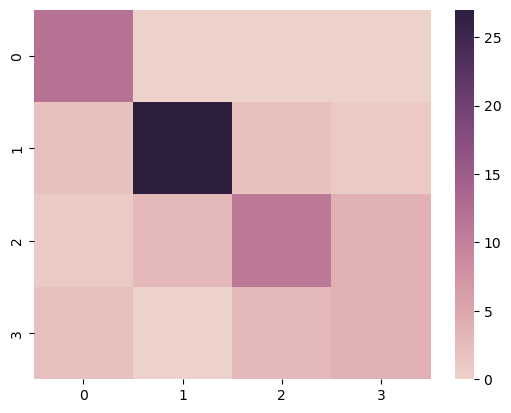

In [455]:
sns.heatmap(data = cf_matrixs, cmap=sns.cubehelix_palette(as_cmap=True))

In [212]:
mods.feature_importances_

array([6.63329391e-04, 1.57574311e-02, 1.13194012e-03, 6.46185438e-04,
       1.38224668e-03, 3.31978851e-04, 4.62173601e-03, 5.01605478e-03,
       1.19926840e-03, 7.76350815e-03, 3.50057626e-03, 2.53211379e-03,
       1.23418594e-03, 8.69826473e-03, 7.12829222e-04, 2.40010772e-04,
       8.04529984e-03, 6.20096943e-03, 7.09752778e-04, 2.55793046e-03,
       1.97181243e-04, 2.42676492e-02, 6.42254255e-03, 4.48259550e-03,
       4.70046653e-04, 2.22781132e-03, 3.44628349e-03, 3.07769341e-03,
       3.68373867e-03, 1.02185424e-03, 4.89888292e-03, 6.45435654e-04,
       1.33788284e-03, 7.91674563e-03, 2.88880167e-03, 6.97403294e-04,
       1.44392743e-03, 4.91903681e-04, 4.87652511e-04, 1.07647730e-04,
       2.30044406e-04, 1.10411624e-03, 1.77807808e-02, 5.34184315e-03,
       8.14092534e-04, 4.28888344e-04, 5.55617365e-03, 7.98832843e-03,
       2.69686186e-03, 2.07277494e-02, 5.69727131e-04, 8.07608363e-03,
       6.38958342e-04, 6.61044390e-04, 9.09288712e-04, 4.32765146e-03,
      

In [213]:
mods1 = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.1)
mods1.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s1 = mods1.predict(X_test_s)

In [214]:
print(f1_score(y_test_s, y_pred_s1, average = 'weighted'))

0.6431177838822055


In [215]:
print(precision_score(y_test_s, y_pred_s1,average='weighted'))

0.7231481481481481


In [216]:
cf_matrixs1 = confusion_matrix(y_test_s, y_pred_s1)

In [217]:
cf_matrixs1

array([[ 8,  3,  2,  0],
       [ 0, 20,  1,  1],
       [ 2,  7, 15,  8],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

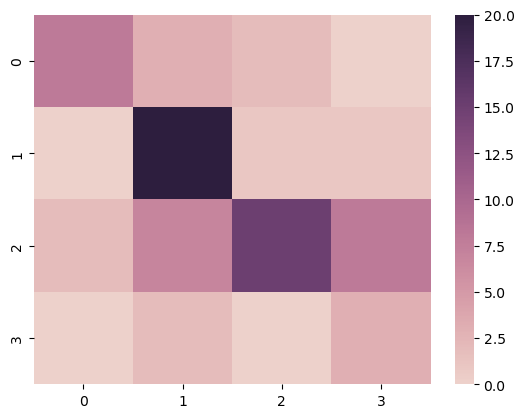

In [218]:
sns.heatmap(data = cf_matrixs1, cmap=sns.cubehelix_palette(as_cmap=True))

In [226]:
mods2 = GradientBoostingClassifier(n_estimators = 150, max_depth=4, learning_rate=0.1)
mods2.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s2 = mods2.predict(X_test_s)

In [227]:
print(f1_score(y_test_s, y_pred_s2, average = 'weighted'))

0.668769909335947


In [228]:
print(precision_score(y_test_s, y_pred_s2,average='weighted'))

0.7297178130511464


In [229]:
cf_matrixs2 = confusion_matrix(y_test_s, y_pred_s2)

In [230]:
cf_matrixs2

array([[ 7,  4,  2,  0],
       [ 0, 20,  1,  1],
       [ 2,  7, 18,  5],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

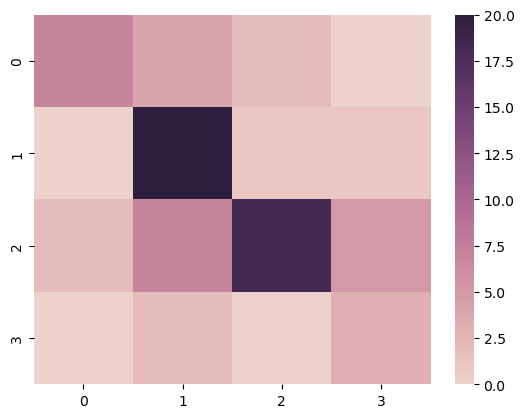

In [231]:
sns.heatmap(data = cf_matrixs2, cmap=sns.cubehelix_palette(as_cmap=True))

In [238]:
mods3 = GradientBoostingClassifier(n_estimators = 50, max_depth=4, learning_rate=0.1)
mods3.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s3 = mods3.predict(X_test_s)

In [239]:
print(f1_score(y_test_s, y_pred_s3, average = 'weighted'))

0.6186483729294188


In [240]:
print(precision_score(y_test_s, y_pred_s3,average='weighted'))

0.6703216374269005


In [241]:
cf_matrixs3 = confusion_matrix(y_test_s, y_pred_s3)

In [242]:
cf_matrixs3

array([[ 7,  3,  3,  0],
       [ 0, 20,  1,  1],
       [ 5,  7, 15,  5],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

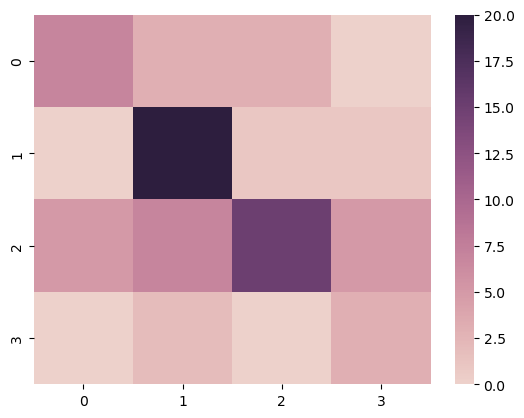

In [243]:
sns.heatmap(data = cf_matrixs3, cmap=sns.cubehelix_palette(as_cmap=True))

In [256]:
mods4 = GradientBoostingClassifier(n_estimators = 200, max_depth=4, learning_rate=0.1)
mods4.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s4 = mods4.predict(X_test_s)

In [257]:
print(f1_score(y_test_s, y_pred_s4, average = 'weighted'))

0.6819296958185848


In [258]:
print(precision_score(y_test_s, y_pred_s4,average='weighted'))

0.7354973344556678


In [259]:
cf_matrixs4 = confusion_matrix(y_test_s, y_pred_s4)

In [260]:
cf_matrixs4

array([[ 7,  4,  2,  0],
       [ 0, 20,  1,  1],
       [ 2,  7, 19,  4],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

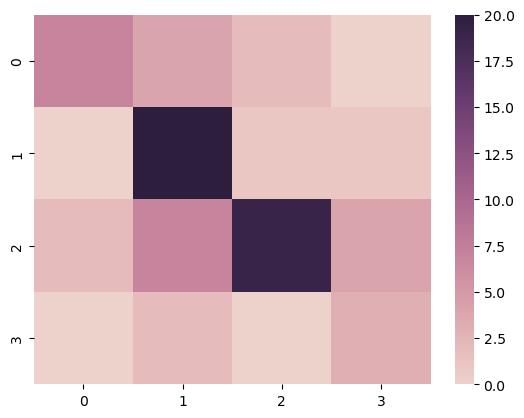

In [261]:
sns.heatmap(data = cf_matrixs4, cmap=sns.cubehelix_palette(as_cmap=True))

In [268]:
mods5 = GradientBoostingClassifier(n_estimators = 250, max_depth=4, learning_rate=0.1)
mods5.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s5 = mods5.predict(X_test_s)

In [269]:
print(f1_score(y_test_s, y_pred_s5, average = 'weighted'))

0.6119372431587785


In [270]:
print(precision_score(y_test_s, y_pred_s5,average='weighted'))

0.671875


In [271]:
cf_matrixs5 = confusion_matrix(y_test_s, y_pred_s5)

In [272]:
cf_matrixs5

array([[ 5,  4,  4,  0],
       [ 0, 21,  1,  0],
       [ 2,  9, 16,  5],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

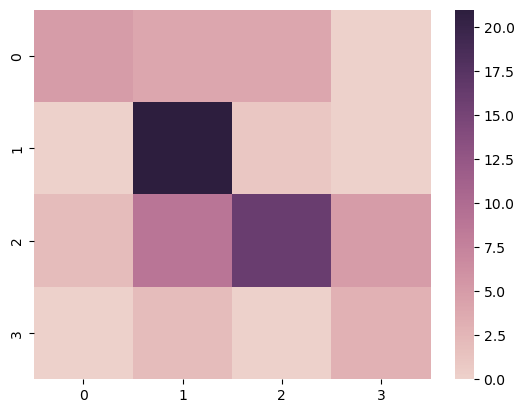

In [273]:
sns.heatmap(data = cf_matrixs5, cmap=sns.cubehelix_palette(as_cmap=True))

In [286]:
mods6 = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.15)
mods6.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s6 = mods6.predict(X_test_s)

In [287]:
print(f1_score(y_test_s, y_pred_s6, average = 'weighted'))

0.6483571983571984


In [288]:
print(precision_score(y_test_s, y_pred_s6,average='weighted'))

0.6944696054750403


In [289]:
cf_matrixs6 = confusion_matrix(y_test_s, y_pred_s6)

In [290]:
cf_matrixs6

array([[ 6,  3,  4,  0],
       [ 0, 20,  1,  1],
       [ 2,  8, 18,  4],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

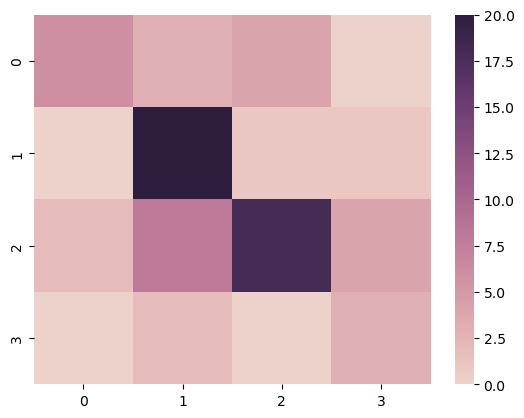

In [291]:
sns.heatmap(data = cf_matrixs6, cmap=sns.cubehelix_palette(as_cmap=True))

In [298]:
mods7 = GradientBoostingClassifier(n_estimators = 150, max_depth=4, learning_rate=0.15)
mods7.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s7 = mods7.predict(X_test_s)

In [299]:
print(f1_score(y_test_s, y_pred_s7, average = 'weighted'))

0.6028084493203658


In [300]:
print(precision_score(y_test_s, y_pred_s7,average='weighted'))

0.6653439153439153


In [301]:
cf_matrixs7 = confusion_matrix(y_test_s, y_pred_s7)

In [302]:
cf_matrixs7

array([[ 5,  4,  4,  0],
       [ 0, 20,  1,  1],
       [ 2,  9, 16,  5],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

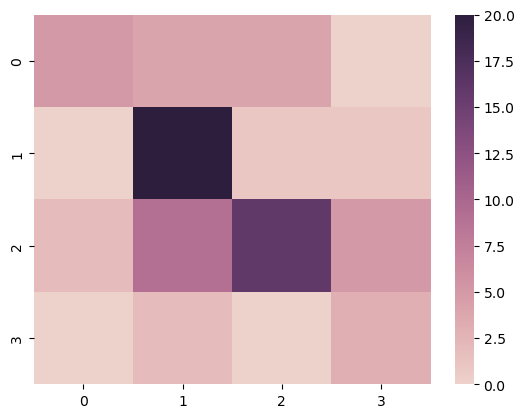

In [303]:
sns.heatmap(data = cf_matrixs7, cmap=sns.cubehelix_palette(as_cmap=True))

In [310]:
mods8 = GradientBoostingClassifier(n_estimators = 50, max_depth=4, learning_rate=0.15)
mods8.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s8 = mods8.predict(X_test_s)

In [311]:
print(f1_score(y_test_s, y_pred_s8, average = 'weighted'))

0.607843137254902


In [312]:
print(precision_score(y_test_s, y_pred_s8,average='weighted'))

0.6949705387205387


In [313]:
cf_matrixs8 = confusion_matrix(y_test_s, y_pred_s8)

In [314]:
cf_matrixs8

array([[ 8,  3,  2,  0],
       [ 0, 20,  1,  1],
       [ 3,  8, 13,  8],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

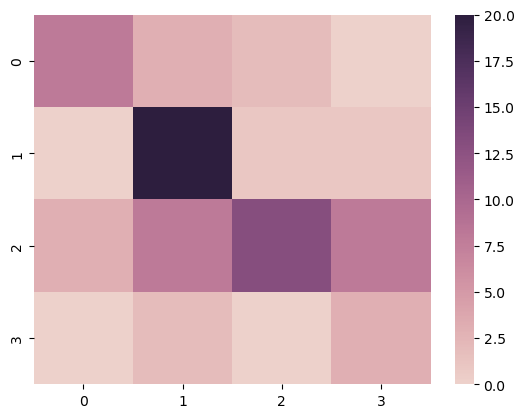

In [315]:
sns.heatmap(data = cf_matrixs8, cmap=sns.cubehelix_palette(as_cmap=True))

In [322]:
mods9 = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.08)
mods9.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s9 = mods9.predict(X_test_s)

In [323]:
print(f1_score(y_test_s, y_pred_s9, average = 'weighted'))

0.5750382008595402


In [324]:
print(precision_score(y_test_s, y_pred_s9,average='weighted'))

0.6675542186571598


In [325]:
cf_matrixs9 = confusion_matrix(y_test_s, y_pred_s9)

In [326]:
cf_matrixs9

array([[ 7,  4,  2,  0],
       [ 0, 20,  1,  1],
       [ 4,  8, 12,  8],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

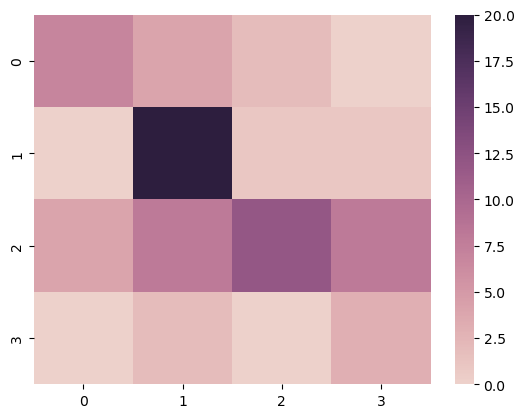

In [327]:
sns.heatmap(data = cf_matrixs9, cmap=sns.cubehelix_palette(as_cmap=True))

In [334]:
mods10 = GradientBoostingClassifier(n_estimators = 150, max_depth=4, learning_rate=0.08)
mods10.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s10 = mods10.predict(X_test_s)

In [335]:
print(f1_score(y_test_s, y_pred_s10, average = 'weighted'))

0.6384032634032635


In [336]:
print(precision_score(y_test_s, y_pred_s10,average='weighted'))

0.7020061728395062


In [337]:
cf_matrixs10 = confusion_matrix(y_test_s, y_pred_s10)

In [338]:
cf_matrixs10

array([[ 7,  3,  3,  0],
       [ 0, 20,  1,  1],
       [ 2,  8, 16,  6],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

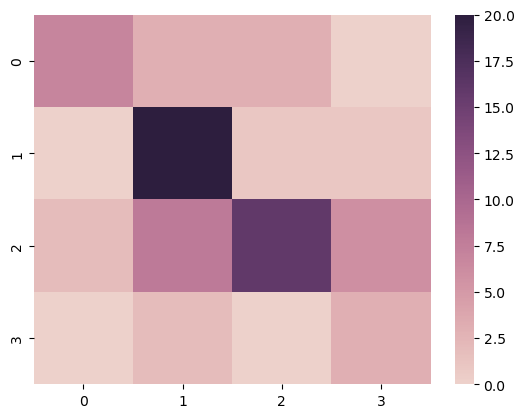

In [339]:
sns.heatmap(data = cf_matrixs10, cmap=sns.cubehelix_palette(as_cmap=True))

In [346]:
mods11 = GradientBoostingClassifier(n_estimators = 200, max_depth=4, learning_rate=0.08)
mods11.fit(X_train_s, y_train_s)
# make a single prediction
y_pred_s11 = mods11.predict(X_test_s)

In [347]:
print(f1_score(y_test_s, y_pred_s11, average = 'weighted'))

0.5948272642390289


In [348]:
print(precision_score(y_test_s, y_pred_s11,average='weighted'))

0.6781953522149601


In [349]:
cf_matrixs11 = confusion_matrix(y_test_s, y_pred_s11)

In [350]:
cf_matrixs11

array([[ 6,  4,  3,  0],
       [ 0, 20,  1,  1],
       [ 2,  8, 14,  8],
       [ 0,  2,  0,  3]], dtype=int64)

<Axes: >

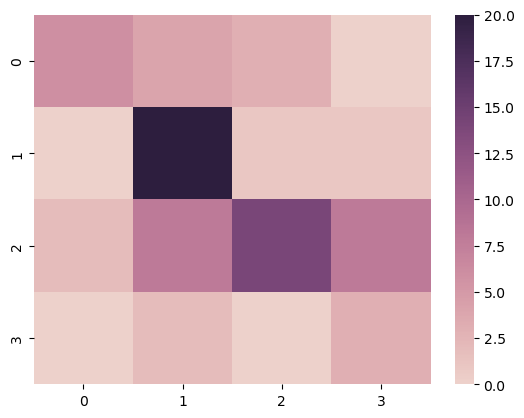

In [351]:
sns.heatmap(data = cf_matrixs11, cmap=sns.cubehelix_palette(as_cmap=True))

# scaled but no lagged_lagged and no future

In [421]:
group_scaled.head()

,Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,...,5_past_exitmidentry_duration,mean_2_past_exitmidentry_duration,mean_3_past_exitmidentry_duration,mean_4_past_exitmidentry_duration,mean_5_past_exitmidentry_duration,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
0,0.218849,0.216137,0.213425,0.343616,0.373452,0.288438,0.412187,0.412187,0.505000,0.010000,...,2.120918,0.494898,0.535306,0.527730,0.424184,3,4,3,2,1
1,0.151041,0.218849,0.216137,0.213425,0.343616,0.319375,0.288438,0.412187,0.412187,0.505000,...,2.575510,0.469643,0.484796,0.517628,0.515102,3,3,4,3,2
2,0.205288,0.151041,0.218849,0.216137,0.213425,0.505000,0.319375,0.288438,0.412187,0.412187,...,2.636122,0.515102,0.501633,0.505000,0.527224,4,3,3,4,3
3,0.186301,0.205288,0.151041,0.218849,0.216137,0.474062,0.505000,0.319375,0.288438,0.412187,...,2.525000,0.535306,0.511735,0.502474,0.505000,3,4,3,3,4
4,0.153753,0.186301,0.205288,0.151041,0.218849,0.969063,0.474062,0.505000,0.319375,0.288438,...,2.838163,0.666633,0.632959,0.590867,0.567633,3,3,4,3,3


In [354]:
group_scaled = group_scaled.reset_index(drop=True)

In [422]:
x_sc_lf= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity', 'lagged_1_current_coeff', 
        'lagged_2_current_coeff','lagged_3_current_coeff', 'lagged_4_current_coeff','lagged_1_lagged_1_cur_coeff','lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop','lagged_4_current_coeff_time_prop','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop']).values

In [423]:
y_sc_lf = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [424]:
X_train_slf, X_test_slf, y_train_slf, y_test_slf = train_test_split(x_sc_lf, y_sc_lf, test_size=0.2, random_state=50)

In [462]:
modslf = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.05)
modslf.fit(X_train_slf, y_train_slf)
# make a single prediction
y_pred_slf = modslf.predict(X_test_slf)

In [463]:
print(f1_score(y_test_slf, y_pred_slf, average = 'weighted'))

0.6983246687547764


In [464]:
print(precision_score(y_test_slf, y_pred_slf,average='weighted'))

0.7057098765432099


In [465]:
cf_matrixslf = confusion_matrix(y_test_slf, y_pred_slf)

In [466]:
cf_matrixslf

array([[ 8,  0,  4,  0],
       [ 2, 27,  1,  2],
       [ 2,  3, 11,  3],
       [ 3,  0,  2,  4]], dtype=int64)

<Axes: >

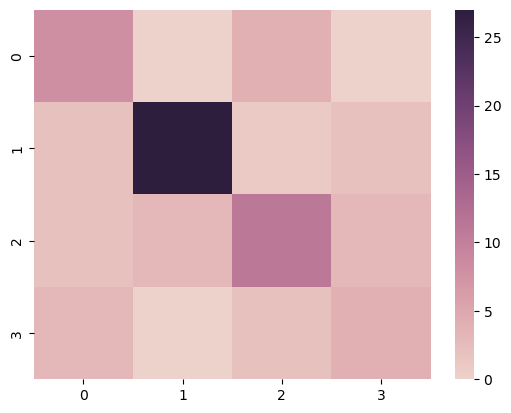

In [467]:
sns.heatmap(data = cf_matrixslf, cmap=sns.cubehelix_palette(as_cmap=True))

# scaled but no lagged_lagged, no future, no prev choice

In [471]:
group_scaled.columns

Index(['Duration', 'lagged_1_duration', 'lagged_2_duration',
       'lagged_3_duration', 'lagged_4_duration', 'Entry Latency',
       'lagged_1_entry_lat', 'lagged_2_entry_lat', 'lagged_3_entry_lat',
       'lagged_4_entry_lat',
       ...
       '5_past_exitmidentry_duration', 'mean_2_past_exitmidentry_duration',
       'mean_3_past_exitmidentry_duration',
       'mean_4_past_exitmidentry_duration',
       'mean_5_past_exitmidentry_duration', 'Choice Output',
       'lagged_1_choice_ago', 'lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago'],
      dtype='object', length=176)

In [469]:
group_scaled = group_scaled.reset_index(drop=True)

In [472]:
x_sc_lfc= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity', 'lagged_1_current_coeff', 
        'lagged_2_current_coeff','lagged_3_current_coeff', 'lagged_4_current_coeff','lagged_1_lagged_1_cur_coeff','lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop','lagged_4_current_coeff_time_prop','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop', 'lagged_1_choice_ago', 
        'lagged_2_choice_ago', 'lagged_3_choice_ago','lagged_4_choice_ago']).values

In [474]:
y_sc_lfc = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [475]:
X_train_slfc, X_test_slfc, y_train_slfc, y_test_slfc = train_test_split(x_sc_lfc, y_sc_lfc, test_size=0.2, random_state=50)

In [488]:
modslfc = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.1)
modslfc.fit(X_train_slfc, y_train_slfc)
# make a single prediction
y_pred_slfc = modslfc.predict(X_test_slfc)

In [489]:
print(f1_score(y_test_slfc, y_pred_slfc, average = 'weighted'))

0.6677232546134985


In [490]:
print(precision_score(y_test_slfc, y_pred_slfc,average='weighted'))

0.6724590373783923


In [491]:
cf_matrixslfc = confusion_matrix(y_test_slfc, y_pred_slfc)

In [492]:
cf_matrixslfc

array([[ 9,  1,  2,  0],
       [ 0, 24,  5,  3],
       [ 2,  6, 11,  0],
       [ 1,  0,  4,  4]], dtype=int64)

<Axes: >

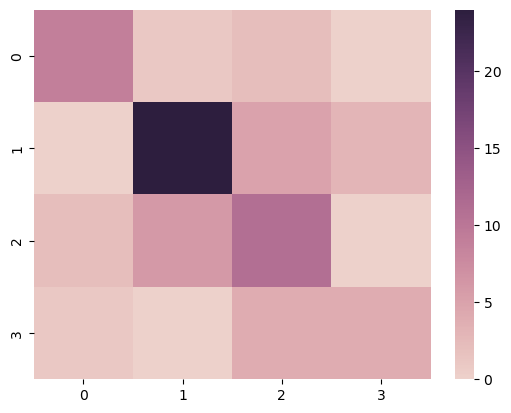

In [493]:
sns.heatmap(data = cf_matrixslfc, cmap=sns.cubehelix_palette(as_cmap=True))

In [543]:
modslfc.feature_importances_

array([4.23057256e-03, 4.45972227e-03, 1.93696834e-03, 3.47509145e-03,
       1.49361879e-02, 9.62931552e-03, 1.89363977e-02, 6.13185838e-03,
       6.73314541e-03, 1.42968190e-02, 3.76503897e-03, 1.29289059e-02,
       1.00661162e-02, 5.23149613e-03, 3.90160140e-03, 6.87804369e-03,
       8.55645158e-03, 2.11148787e-03, 1.06856764e-02, 9.08665917e-03,
       2.65386885e-03, 2.71865074e-02, 5.28471605e-03, 6.59419873e-03,
       2.43454347e-02, 5.67903787e-03, 1.16637834e-02, 1.29076280e-02,
       2.02661180e-02, 5.31482104e-03, 8.87539279e-03, 9.19633480e-03,
       7.45418360e-03, 1.27700841e-03, 1.33717258e-02, 7.23933186e-03,
       1.55991505e-02, 5.74780556e-03, 4.77627762e-04, 1.09700180e-02,
       1.32472842e-02, 1.02517799e-02, 9.79065373e-03, 2.55680441e-02,
       1.17838808e-02, 1.68199160e-02, 1.76463274e-02, 1.54012235e-03,
       1.70402751e-03, 1.22606030e-02, 3.70510848e-03, 1.68790541e-02,
       1.48122674e-02, 1.76546685e-02, 1.56004925e-03, 2.74013758e-03,
      

# only prev choice and lags (no future)

In [498]:
group_scaled.head()

,Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,...,5_past_exitmidentry_duration,mean_2_past_exitmidentry_duration,mean_3_past_exitmidentry_duration,mean_4_past_exitmidentry_duration,mean_5_past_exitmidentry_duration,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
0,0.218849,0.216137,0.213425,0.343616,0.373452,0.288438,0.412187,0.412187,0.505000,0.010000,...,2.120918,0.494898,0.535306,0.527730,0.424184,3,4,3,2,1
1,0.151041,0.218849,0.216137,0.213425,0.343616,0.319375,0.288438,0.412187,0.412187,0.505000,...,2.575510,0.469643,0.484796,0.517628,0.515102,3,3,4,3,2
2,0.205288,0.151041,0.218849,0.216137,0.213425,0.505000,0.319375,0.288438,0.412187,0.412187,...,2.636122,0.515102,0.501633,0.505000,0.527224,4,3,3,4,3
3,0.186301,0.205288,0.151041,0.218849,0.216137,0.474062,0.505000,0.319375,0.288438,0.412187,...,2.525000,0.535306,0.511735,0.502474,0.505000,3,4,3,3,4
4,0.153753,0.186301,0.205288,0.151041,0.218849,0.969063,0.474062,0.505000,0.319375,0.288438,...,2.838163,0.666633,0.632959,0.590867,0.567633,3,3,4,3,3


In [499]:
group_scaled = group_scaled.reset_index(drop=True)

In [500]:
x_sc_p= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity', 'lagged_1_current_coeff', 
        'lagged_2_current_coeff','lagged_3_current_coeff', 'lagged_4_current_coeff','lagged_1_lagged_1_cur_coeff','lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop','lagged_4_current_coeff_time_prop','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop', 
        'lagged_2_duration','lagged_3_duration', 'lagged_4_duration','lagged_1_entry_lat', 'lagged_2_entry_lat', 'lagged_3_entry_lat',
       'lagged_4_entry_lat','lagged_2_exit_lat', 'lagged_3_exit_lat', 'lagged_4_exit_lat','lagged_2_arm_nose_mov',
       'lagged_3_arm_nose_mov', 'lagged_4_arm_nose_mov','lagged_2_arm_nose_vel','lagged_3_arm_nose_vel', 'lagged_4_arm_nose_vel','lagged_2_arm_tail_mov',
       'lagged_3_arm_tail_mov', 'lagged_4_arm_tail_mov','lagged_2_arm_tail_vel','lagged_3_arm_tail_vel', 'lagged_4_arm_tail_vel','lagged_1_mid_duration', 
        'lagged_2_mid_duration','lagged_3_mid_duration', 'lagged_4_mid_duration','lagged_1_mid_nose_mov','lagged_2_mid_nose_mov', 'lagged_3_mid_nose_mov',
       'lagged_4_mid_nose_mov','lagged_1_mid_nose_vel', 'lagged_2_mid_nose_vel','lagged_3_mid_nose_vel', 'lagged_4_mid_nose_vel','lagged_1_mid_tail_mov',
       'lagged_2_mid_tail_mov', 'lagged_3_mid_tail_mov','lagged_4_mid_tail_mov', 'lagged_1_mid_tail_vel', 'lagged_2_mid_tail_vel','lagged_3_mid_tail_vel', 'lagged_4_mid_tail_vel', 'ExitMid Duration',
       'lagged_1_exitmid_duration', 'lagged_2_exitmid_duration','lagged_3_exitmid_duration', 'lagged_4_exitmid_duration','lagged_1_midentry_duration',
       'lagged_2_midentry_duration', 'lagged_3_midentry_duration','lagged_4_midentry_duration', 'lagged_1_exitmidentry_duration', 
        'lagged_2_exitmidentry_duration','lagged_3_exitmidentry_duration', 'lagged_4_exitmidentry_duration','Lagged 1 Cur Coeff','Lagged 2 Cur Coeff',
        'Lagged 3 Cur Coeff','Lagged 4 Cur Coeff','Lagged 1 Cur Coeff Time Proportional','Lagged 2 Cur Coeff Time Proportional',
        'Lagged 3 Cur Coeff Time Proportional','Lagged 4 Cur Coeff Time Proportional', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration',
       'mean_2_cur_arm_duration', 'mean_3_cur_arm_duration',
       'mean_4_cur_arm_duration', 'mean_5_cur_arm_duration',
       '2_past_arm_duration', '3_past_arm_duration', '4_past_arm_duration',
       'mean_2_past_arm_duration', 'mean_3_past_arm_duration',
       'mean_4_past_arm_duration', '2_past_mid_duration',
       '3_past_mid_duration', '4_past_mid_duration', '5_past_mid_duration',
       'mean_2_past_mid_duration', 'mean_3_past_mid_duration',
       'mean_4_past_mid_duration', 'mean_5_past_mid_duration',
       '2_past_exitmid_duration', '3_past_exitmid_duration',
       '4_past_exitmid_duration', '5_past_exitmid_duration',
       'mean_2_past_exitmid_duration', 'mean_3_past_exitmid_duration',
       'mean_4_past_exitmid_duration', 'mean_5_past_exitmid_duration',
       '2_past_midentry_duration', '3_past_midentry_duration',
       '4_past_midentry_duration', '5_past_midentry_duration',
       'mean_2_past_midentry_duration', 'mean_3_past_midentry_duration',
       'mean_4_past_midentry_duration', 'mean_5_past_midentry_duration',
       '2_past_exitmidentry_duration', '3_past_exitmidentry_duration',
       '4_past_exitmidentry_duration', '5_past_exitmidentry_duration',
       'mean_2_past_exitmidentry_duration',
       'mean_3_past_exitmidentry_duration',
       'mean_4_past_exitmidentry_duration',
       'mean_5_past_exitmidentry_duration','lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago']).values

In [505]:
y_sc_p = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [506]:
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(x_sc_p, y_sc_p, test_size=0.2, random_state=50)

In [555]:
modsp = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.075)
modsp.fit(X_train_sp, y_train_sp)
# make a single prediction
y_pred_sp = modsp.predict(X_test_sp)

In [556]:
print(f1_score(y_test_sp, y_pred_sp, average = 'weighted'))

0.5793912657319431


In [557]:
print(precision_score(y_test_sp, y_pred_sp,average='weighted'))

0.6159140338827839


In [558]:
cf_matrixsp = confusion_matrix(y_test_sp, y_pred_sp)

In [559]:
cf_matrixsp

array([[ 4,  4,  3,  1],
       [ 2, 18, 12,  0],
       [ 1,  2, 15,  1],
       [ 0,  2,  2,  5]], dtype=int64)

<Axes: >

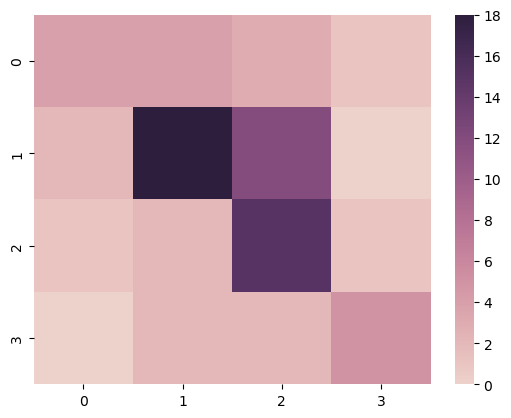

In [560]:
sns.heatmap(data = cf_matrixsp, cmap=sns.cubehelix_palette(as_cmap=True))

In [564]:
modsp.feature_importances_

array([0.03027614, 0.04655842, 0.04053107, 0.05323035, 0.06586304,
       0.06554325, 0.07121924, 0.03261498, 0.04532743, 0.04351092,
       0.03435482, 0.05677524, 0.04630094, 0.04800539, 0.07984688,
       0.04661728, 0.19342462])

# only prev choice and lags (no future) no prev choice

In [498]:
group_scaled.head()

,Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,...,5_past_exitmidentry_duration,mean_2_past_exitmidentry_duration,mean_3_past_exitmidentry_duration,mean_4_past_exitmidentry_duration,mean_5_past_exitmidentry_duration,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
0,0.218849,0.216137,0.213425,0.343616,0.373452,0.288438,0.412187,0.412187,0.505000,0.010000,...,2.120918,0.494898,0.535306,0.527730,0.424184,3,4,3,2,1
1,0.151041,0.218849,0.216137,0.213425,0.343616,0.319375,0.288438,0.412187,0.412187,0.505000,...,2.575510,0.469643,0.484796,0.517628,0.515102,3,3,4,3,2
2,0.205288,0.151041,0.218849,0.216137,0.213425,0.505000,0.319375,0.288438,0.412187,0.412187,...,2.636122,0.515102,0.501633,0.505000,0.527224,4,3,3,4,3
3,0.186301,0.205288,0.151041,0.218849,0.216137,0.474062,0.505000,0.319375,0.288438,0.412187,...,2.525000,0.535306,0.511735,0.502474,0.505000,3,4,3,3,4
4,0.153753,0.186301,0.205288,0.151041,0.218849,0.969063,0.474062,0.505000,0.319375,0.288438,...,2.838163,0.666633,0.632959,0.590867,0.567633,3,3,4,3,3


In [499]:
group_scaled = group_scaled.reset_index(drop=True)

In [728]:
x_sc_p1= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity', 'lagged_1_current_coeff', 
        'lagged_2_current_coeff','lagged_3_current_coeff', 'lagged_4_current_coeff','lagged_1_lagged_1_cur_coeff','lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop','lagged_4_current_coeff_time_prop','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop', 
        'lagged_2_duration','lagged_3_duration', 'lagged_4_duration','lagged_1_entry_lat', 'lagged_2_entry_lat', 'lagged_3_entry_lat',
       'lagged_4_entry_lat','lagged_2_exit_lat', 'lagged_3_exit_lat', 'lagged_4_exit_lat','lagged_2_arm_nose_mov',
       'lagged_3_arm_nose_mov', 'lagged_4_arm_nose_mov','lagged_2_arm_nose_vel','lagged_3_arm_nose_vel', 'lagged_4_arm_nose_vel','lagged_2_arm_tail_mov',
       'lagged_3_arm_tail_mov', 'lagged_4_arm_tail_mov','lagged_2_arm_tail_vel','lagged_3_arm_tail_vel', 'lagged_4_arm_tail_vel','lagged_1_mid_duration', 
        'lagged_2_mid_duration','lagged_3_mid_duration', 'lagged_4_mid_duration','lagged_1_mid_nose_mov','lagged_2_mid_nose_mov', 'lagged_3_mid_nose_mov',
       'lagged_4_mid_nose_mov','lagged_1_mid_nose_vel', 'lagged_2_mid_nose_vel','lagged_3_mid_nose_vel', 'lagged_4_mid_nose_vel','lagged_1_mid_tail_mov',
       'lagged_2_mid_tail_mov', 'lagged_3_mid_tail_mov','lagged_4_mid_tail_mov', 'lagged_1_mid_tail_vel', 'lagged_2_mid_tail_vel','lagged_3_mid_tail_vel', 'lagged_4_mid_tail_vel', 'ExitMid Duration',
       'lagged_1_exitmid_duration', 'lagged_2_exitmid_duration','lagged_3_exitmid_duration', 'lagged_4_exitmid_duration','lagged_1_midentry_duration',
       'lagged_2_midentry_duration', 'lagged_3_midentry_duration','lagged_4_midentry_duration', 'lagged_1_exitmidentry_duration', 
        'lagged_2_exitmidentry_duration','lagged_3_exitmidentry_duration', 'lagged_4_exitmidentry_duration','Lagged 1 Cur Coeff','Lagged 2 Cur Coeff',
        'Lagged 3 Cur Coeff','Lagged 4 Cur Coeff','Lagged 1 Cur Coeff Time Proportional','Lagged 2 Cur Coeff Time Proportional',
        'Lagged 3 Cur Coeff Time Proportional','Lagged 4 Cur Coeff Time Proportional', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration',
       'mean_2_cur_arm_duration', 'mean_3_cur_arm_duration',
       'mean_4_cur_arm_duration', 'mean_5_cur_arm_duration',
       '2_past_arm_duration', '3_past_arm_duration', '4_past_arm_duration',
       'mean_2_past_arm_duration', 'mean_3_past_arm_duration',
       'mean_4_past_arm_duration', '2_past_mid_duration',
       '3_past_mid_duration', '4_past_mid_duration', '5_past_mid_duration',
       'mean_2_past_mid_duration', 'mean_3_past_mid_duration',
       'mean_4_past_mid_duration', 'mean_5_past_mid_duration',
       '2_past_exitmid_duration', '3_past_exitmid_duration',
       '4_past_exitmid_duration', '5_past_exitmid_duration',
       'mean_2_past_exitmid_duration', 'mean_3_past_exitmid_duration',
       'mean_4_past_exitmid_duration', 'mean_5_past_exitmid_duration',
       '2_past_midentry_duration', '3_past_midentry_duration',
       '4_past_midentry_duration', '5_past_midentry_duration',
       'mean_2_past_midentry_duration', 'mean_3_past_midentry_duration',
       'mean_4_past_midentry_duration', 'mean_5_past_midentry_duration',
       '2_past_exitmidentry_duration', '3_past_exitmidentry_duration',
       '4_past_exitmidentry_duration', '5_past_exitmidentry_duration',
       'mean_2_past_exitmidentry_duration',
       'mean_3_past_exitmidentry_duration',
       'mean_4_past_exitmidentry_duration',
       'mean_5_past_exitmidentry_duration', 'lagged_1_choice_ago','lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago']).values

In [2]:
y_sc_p1 = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values|

SyntaxError: invalid syntax (1207479438.py, line 1)

In [3]:
y_sc_p1.size

NameError: name 'y_sc_p1' is not defined

In [731]:
X_train_sp1, X_test_sp1, y_train_sp1, y_test_sp1 = train_test_split(x_sc_p1, y_sc_p1, test_size=0.2, random_state=50)

In [732]:
modsp1 = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.075)
modsp1.fit(X_train_sp1, y_train_sp1)
# make a single prediction
y_pred_sp1 = modsp1.predict(X_test_sp1)

In [733]:
print(f1_score(y_test_sp1, y_pred_sp1, average = 'weighted'))

0.4142886979353145


In [734]:
print(precision_score(y_test_sp1, y_pred_sp1,average='weighted'))

0.4332407407407407


In [736]:
cf_matrixsp1 = confusion_matrix(y_test_sp1, y_pred_sp1)

In [737]:
cf_matrixsp1

array([[ 3,  4,  4,  1],
       [ 3, 12, 15,  2],
       [ 2,  6, 10,  1],
       [ 0,  3,  1,  5]], dtype=int64)

<Axes: >

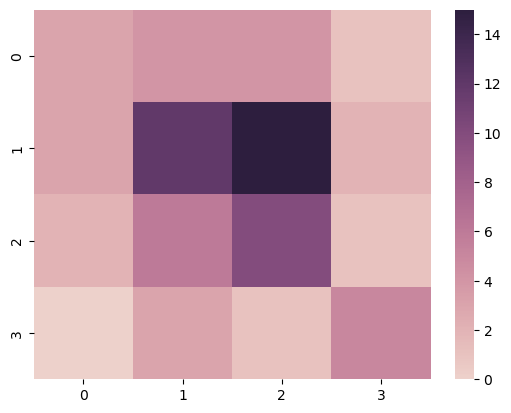

In [738]:
sns.heatmap(data = cf_matrixsp1, cmap=sns.cubehelix_palette(as_cmap=True))

In [739]:
modsp1.feature_importances_

array([0.0484396 , 0.06785843, 0.05873584, 0.09264714, 0.06110581,
       0.06362814, 0.06982292, 0.03918366, 0.06691604, 0.04059927,
       0.04930788, 0.0812922 , 0.04987287, 0.06057239, 0.07780939,
       0.07220843])

# scaled but no future

In [471]:
group_scaled.columns

Index(['Duration', 'lagged_1_duration', 'lagged_2_duration',
       'lagged_3_duration', 'lagged_4_duration', 'Entry Latency',
       'lagged_1_entry_lat', 'lagged_2_entry_lat', 'lagged_3_entry_lat',
       'lagged_4_entry_lat',
       ...
       '5_past_exitmidentry_duration', 'mean_2_past_exitmidentry_duration',
       'mean_3_past_exitmidentry_duration',
       'mean_4_past_exitmidentry_duration',
       'mean_5_past_exitmidentry_duration', 'Choice Output',
       'lagged_1_choice_ago', 'lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago'],
      dtype='object', length=176)

In [469]:
group_scaled = group_scaled.reset_index(drop=True)

In [565]:
x_sc_f= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity','lagged_1_lagged_1_cur_coeff',
        'lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop', ]).values

In [566]:
y_sc_f = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [573]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(x_sc_f, y_sc_f, test_size=0.2, random_state=50)

In [574]:
modsf = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.1)
modsf.fit(X_train_f, y_train_f)
# make a single prediction
y_pred_f = modsf.predict(X_test_f)

In [575]:
print(f1_score(y_test_f, y_pred_f, average = 'weighted'))

0.8001185709519043


In [576]:
print(precision_score(y_test_f, y_pred_f,average='weighted'))

0.8031091767650909


In [577]:
cf_matrixsf = confusion_matrix(y_test_f, y_pred_f)

In [578]:
cf_matrixsf

array([[12,  0,  0,  0],
       [ 1, 28,  1,  2],
       [ 1,  3, 14,  1],
       [ 2,  0,  3,  4]], dtype=int64)

<Axes: >

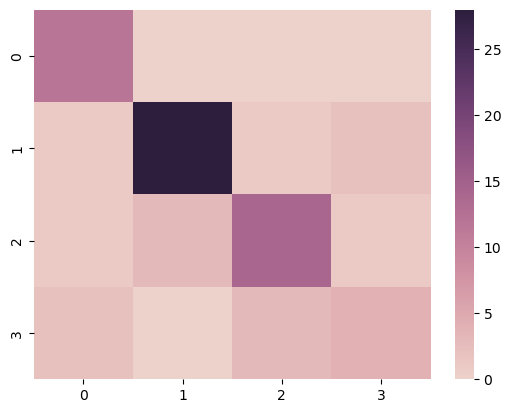

In [579]:
sns.heatmap(data = cf_matrixsf, cmap=sns.cubehelix_palette(as_cmap=True))

In [580]:
x_sc_f1= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity','lagged_1_lagged_1_cur_coeff',
        'lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop', ]).values

In [581]:
y_sc_f1 = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [582]:
X_train_f1, X_test_f1, y_train_f1, y_test_f1 = train_test_split(x_sc_f1, y_sc_f1, test_size=0.2, random_state=50)

In [601]:
modsf1 = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.2)
modsf1.fit(X_train_f1, y_train_f1)
# make a single prediction
y_pred_f1 = modsf1.predict(X_test_f1)

In [602]:
print(f1_score(y_test_f1, y_pred_f1, average = 'weighted'))

0.8163728632478633


In [603]:
print(precision_score(y_test_f1, y_pred_f1,average='weighted'))

0.8174603174603176


In [604]:
cf_matrixsf1 = confusion_matrix(y_test_f1, y_pred_f1)

In [605]:
cf_matrixsf1

array([[11,  0,  1,  0],
       [ 1, 29,  1,  1],
       [ 1,  3, 14,  1],
       [ 1,  0,  3,  5]], dtype=int64)

<Axes: >

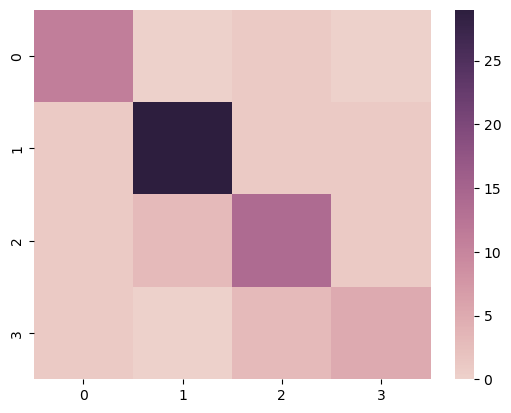

In [606]:
sns.heatmap(data = cf_matrixsf1, cmap=sns.cubehelix_palette(as_cmap=True))

In [607]:
modsf1.feature_importances_

array([5.62387255e-03, 2.76656529e-03, 3.21723590e-03, 9.55759105e-04,
       3.31631942e-03, 1.38139718e-02, 1.79145404e-02, 3.92542943e-03,
       1.74262795e-03, 1.13045679e-02, 7.79565900e-03, 7.50129542e-03,
       3.45242507e-03, 1.77371747e-02, 2.56181125e-03, 9.57160108e-03,
       4.39642570e-03, 5.68648433e-03, 3.83077957e-03, 8.06931945e-03,
       1.26309351e-03, 1.15816369e-02, 1.18459121e-03, 3.92437385e-03,
       8.89922139e-03, 3.34645649e-03, 6.07483741e-03, 1.15149433e-02,
       5.91847171e-04, 5.20332708e-04, 1.80695950e-03, 4.12540179e-03,
       8.83880010e-05, 5.45502050e-04, 4.83717478e-03, 6.59839278e-03,
       2.11503526e-02, 1.95304611e-03, 3.03778500e-04, 1.64131276e-04,
       2.69986916e-03, 5.19255895e-03, 1.42732388e-03, 1.77593031e-02,
       3.21845119e-03, 2.14604189e-02, 1.35300248e-03, 1.56772395e-03,
       4.94573541e-05, 6.41356292e-03, 6.89538014e-04, 1.92076308e-02,
       8.49241832e-03, 9.13449485e-03, 1.25027210e-03, 2.69760252e-06,
      

# scaled but no future and no choice

In [608]:
group_scaled.columns

Index(['Duration', 'lagged_1_duration', 'lagged_2_duration',
       'lagged_3_duration', 'lagged_4_duration', 'Entry Latency',
       'lagged_1_entry_lat', 'lagged_2_entry_lat', 'lagged_3_entry_lat',
       'lagged_4_entry_lat',
       ...
       '5_past_exitmidentry_duration', 'mean_2_past_exitmidentry_duration',
       'mean_3_past_exitmidentry_duration',
       'mean_4_past_exitmidentry_duration',
       'mean_5_past_exitmidentry_duration', 'Choice Output',
       'lagged_1_choice_ago', 'lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago'],
      dtype='object', length=176)

In [469]:
group_scaled = group_scaled.reset_index(drop=True)

In [609]:
x_sc_fc= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity','lagged_1_lagged_1_cur_coeff',
        'lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop', 'lagged_1_choice_ago', 'lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago']).values

In [610]:
y_sc_fc = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [687]:
X_train_fc, X_test_fc, y_train_fc, y_test_fc = train_test_split(x_sc_fc, y_sc_fc, test_size=0.2, random_state=50)

In [694]:
modsfc = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.1)
modsfc.fit(X_train_fc, y_train_fc)
# make a single prediction
y_pred_fc = modsfc.predict(X_test_fc)

In [695]:
print(f1_score(y_test_fc, y_pred_fc, average = 'weighted'))

0.6991070167702741


In [696]:
print(precision_score(y_test_fc, y_pred_fc,average='weighted'))

0.7182449494949495


In [697]:
cf_matrixsfc = confusion_matrix(y_test_fc, y_pred_fc)

In [698]:
cf_matrixsfc

array([[12,  0,  0,  0],
       [ 2, 24,  5,  1],
       [ 1,  6, 12,  0],
       [ 1,  0,  5,  3]], dtype=int64)

<Axes: >

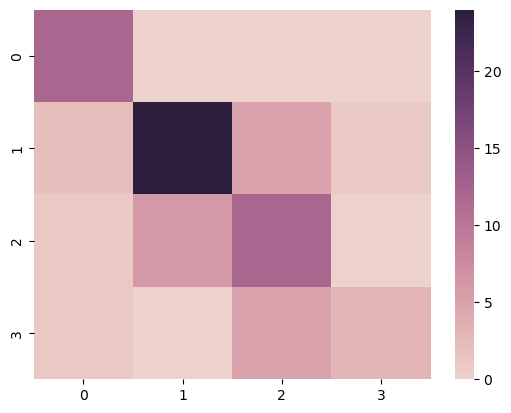

In [699]:
sns.heatmap(data = cf_matrixsfc, cmap=sns.cubehelix_palette(as_cmap=True))

In [726]:
modsfc.feature_importances_

array([2.92094734e-03, 2.60932128e-03, 3.62132747e-03, 2.31284716e-03,
       1.47936889e-02, 1.37655810e-02, 1.47823486e-02, 1.55576273e-03,
       5.45196708e-03, 1.83473315e-02, 2.07564062e-03, 1.18778696e-02,
       1.10930410e-02, 4.24843672e-03, 4.11780507e-03, 8.02690044e-03,
       2.64793840e-03, 3.66505291e-03, 7.22782568e-03, 7.54422020e-03,
       6.56930145e-03, 2.70783313e-02, 1.89232793e-03, 4.57545968e-03,
       2.55626261e-02, 5.24816839e-03, 9.55431413e-03, 8.37812784e-03,
       1.62245731e-02, 5.46289597e-03, 9.86555310e-03, 5.67513997e-03,
       1.93297400e-03, 1.46235088e-03, 6.51434779e-03, 2.32474995e-03,
       1.59223038e-02, 4.38624584e-03, 1.91889493e-03, 2.64388465e-03,
       7.82429096e-03, 7.50428964e-03, 9.06323549e-03, 2.44978569e-02,
       6.29996408e-03, 1.31886607e-02, 6.38473956e-03, 9.52973154e-04,
       1.30696435e-03, 7.74935405e-03, 1.59719585e-03, 1.92689033e-02,
       1.60160946e-02, 1.92514049e-02, 5.83178952e-04, 1.65562548e-03,
      

# scaled but no future and no cumulative just means

In [700]:
group_scaled.columns[100:]

Index(['Current Coeff Time Proportional', 'lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop',
       'lagged_4_current_coeff_time_prop',
       'Lagged 1 Cur Coeff Time Proportional',
       'lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop',
       'lagged_3_lagged_1_cur_coeff_time_prop',
       'lagged_4_lagged_1_cur_coeff_time_prop',
       'Lagged 2 Cur Coeff Time Proportional',
       'lagged_1_lagged_2_cur_coeff_time_prop',
       'lagged_2_lagged_2_cur_coeff_time_prop',
       'lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop',
       'Lagged 3 Cur Coeff Time Proportional',
       'lagged_1_lagged_3_cur_coeff_time_prop',
       'lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop',
       'lagged_4_lagged_3_cur_coeff_time_prop',
       'Lagged 4 Cur Coeff Time Proportional',
       'lagged_1_lagged_4_cur_coeff_

In [469]:
group_scaled = group_scaled.reset_index(drop=True)

In [701]:
x_sc_fm= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity','lagged_1_lagged_1_cur_coeff',
        'lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop',
        '2_past_arm_duration', '3_past_arm_duration', '4_past_arm_duration','2_past_mid_duration',
       '3_past_mid_duration', '4_past_mid_duration', '5_past_mid_duration', '2_past_exitmid_duration', '3_past_exitmid_duration',
       '4_past_exitmid_duration', '5_past_exitmid_duration','2_past_midentry_duration', '3_past_midentry_duration',
       '4_past_midentry_duration', '5_past_midentry_duration','2_past_exitmidentry_duration', '3_past_exitmidentry_duration',
       '4_past_exitmidentry_duration', '5_past_exitmidentry_duration']).values

In [702]:
y_sc_fm = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [703]:
X_train_fm, X_test_fm, y_train_fm, y_test_fm = train_test_split(x_sc_fm, y_sc_fm, test_size=0.2, random_state=50)

In [725]:
x_sc_fm[1,:].size

110

In [710]:
modsfm = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.1)
modsfm.fit(X_train_fm, y_train_fm)
# make a single prediction
y_pred_fm = modsfm.predict(X_test_fm)

In [711]:
print(f1_score(y_test_fm, y_pred_fm, average = 'weighted'))

0.8031436413789356


In [712]:
print(precision_score(y_test_fm, y_pred_fm,average='weighted'))

0.8032131834215168


In [713]:
cf_matrixsfm = confusion_matrix(y_test_fm, y_pred_fm)

In [716]:
cf_matrixsfm

array([[11,  1,  0,  0],
       [ 1, 28,  1,  2],
       [ 1,  3, 14,  1],
       [ 1,  0,  3,  5]], dtype=int64)

<Axes: >

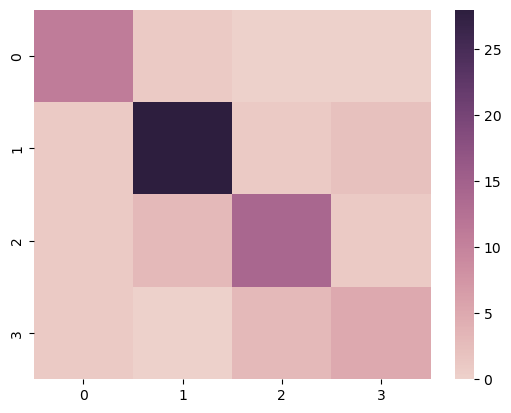

In [717]:
sns.heatmap(data = cf_matrixsfm, cmap=sns.cubehelix_palette(as_cmap=True))

In [718]:
X_train_fm1, X_test_fm1, y_train_fm1, y_test_fm1 = train_test_split(x_sc_fm, y_sc_fm, test_size=0.2, random_state=50)

In [719]:
modsfm1 = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.2)
modsfm1.fit(X_train_fm1, y_train_fm1)
# make a single prediction
y_pred_fm1 = modsfm1.predict(X_test_fm1)

In [720]:
print(f1_score(y_test_fm1, y_pred_fm1, average = 'weighted'))

0.8163728632478633


In [721]:
print(precision_score(y_test_fm1, y_pred_fm1,average='weighted'))

0.8174603174603176


In [722]:
cf_matrixsfm1 = confusion_matrix(y_test_fm1, y_pred_fm1)

In [723]:
cf_matrixsfm1

array([[11,  0,  1,  0],
       [ 1, 29,  1,  1],
       [ 1,  3, 14,  1],
       [ 1,  0,  3,  5]], dtype=int64)

<Axes: >

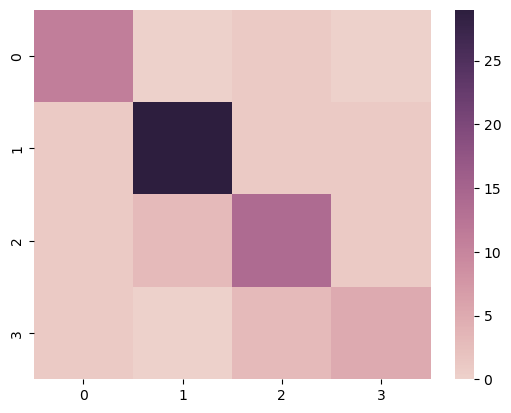

In [724]:
sns.heatmap(data = cf_matrixsfm1, cmap=sns.cubehelix_palette(as_cmap=True))

# scaled but no future and no cumulative just means, no choice, no lags

In [768]:
group_scaled.columns[100:]

Index(['Current Coeff Time Proportional', 'lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop',
       'lagged_4_current_coeff_time_prop',
       'Lagged 1 Cur Coeff Time Proportional',
       'lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop',
       'lagged_3_lagged_1_cur_coeff_time_prop',
       'lagged_4_lagged_1_cur_coeff_time_prop',
       'Lagged 2 Cur Coeff Time Proportional',
       'lagged_1_lagged_2_cur_coeff_time_prop',
       'lagged_2_lagged_2_cur_coeff_time_prop',
       'lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop',
       'Lagged 3 Cur Coeff Time Proportional',
       'lagged_1_lagged_3_cur_coeff_time_prop',
       'lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop',
       'lagged_4_lagged_3_cur_coeff_time_prop',
       'Lagged 4 Cur Coeff Time Proportional',
       'lagged_1_lagged_4_cur_coeff_

In [469]:
group_scaled = group_scaled.reset_index(drop=True)

In [780]:
x_sc_fml= group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity','lagged_1_lagged_1_cur_coeff',
        'lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop',
        '2_past_arm_duration', '3_past_arm_duration', '4_past_arm_duration','2_past_mid_duration',
       '3_past_mid_duration', '4_past_mid_duration', '5_past_mid_duration', '2_past_exitmid_duration', '3_past_exitmid_duration',
       '4_past_exitmid_duration', '5_past_exitmid_duration','2_past_midentry_duration', '3_past_midentry_duration',
       '4_past_midentry_duration', '5_past_midentry_duration','2_past_exitmidentry_duration', '3_past_exitmidentry_duration',
       '4_past_exitmidentry_duration', '5_past_exitmidentry_duration','lagged_1_choice_ago', 'lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago','lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop',
       'lagged_4_current_coeff_time_prop','lagged_1_current_coeff', 'lagged_2_current_coeff',
       'lagged_3_current_coeff', 'lagged_4_current_coeff','Lagged 2 Cur Coeff Time Proportional']).values

In [781]:
y_sc_fml = group_scaled[group_scaled['Choice Output'] > 1]['Choice Output'].values

In [782]:
X_train_fml, X_test_fml, y_train_fml, y_test_fml = train_test_split(x_sc_fml, y_sc_fml, test_size=0.2, random_state=50)

In [783]:
x_sc_fml[1,:].size

97

In [784]:
modsfml = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.1)
modsfml.fit(X_train_fml, y_train_fml)
# make a single prediction
y_pred_fml = modsfml.predict(X_test_fml)

In [785]:
print(f1_score(y_test_fml, y_pred_fml, average = 'weighted'))

0.6504232804232803


In [786]:
print(precision_score(y_test_fml, y_pred_fml,average='weighted'))

0.6606783663585908


In [787]:
cf_matrixsfml = confusion_matrix(y_test_fml, y_pred_fml)

In [788]:
cf_matrixsfml

array([[ 9,  1,  2,  0],
       [ 1, 24,  5,  2],
       [ 2,  6, 11,  0],
       [ 1,  0,  5,  3]], dtype=int64)

<Axes: >

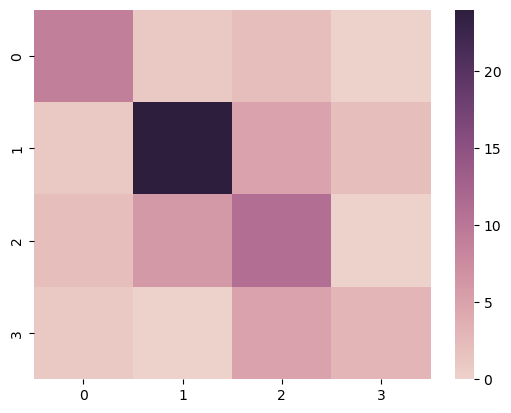

In [789]:
sns.heatmap(data = cf_matrixsfml, cmap=sns.cubehelix_palette(as_cmap=True))

In [790]:
modsfml.feature_importances_

array([0.00343864, 0.00747908, 0.00326858, 0.00287172, 0.0119534 ,
       0.01068315, 0.01622348, 0.00433981, 0.00708201, 0.01582515,
       0.00029497, 0.01309309, 0.0142887 , 0.00466816, 0.00626832,
       0.01048885, 0.00604373, 0.002077  , 0.01719737, 0.00638152,
       0.00328655, 0.02791845, 0.00518663, 0.0027698 , 0.02695365,
       0.00408428, 0.01385217, 0.01303369, 0.01873259, 0.00711245,
       0.00567327, 0.01132474, 0.00473496, 0.0028292 , 0.01306915,
       0.00843876, 0.01890498, 0.00474095, 0.00047557, 0.00818452,
       0.00801788, 0.00776844, 0.00982483, 0.02973541, 0.01175405,
       0.01894935, 0.01486943, 0.00359338, 0.00298955, 0.00762626,
       0.00347645, 0.01886974, 0.01700157, 0.01938204, 0.00071462,
       0.0040426 , 0.00802095, 0.00473048, 0.00277312, 0.00289945,
       0.00297448, 0.00455143, 0.00022949, 0.00470235, 0.00552905,
       0.00124601, 0.00144209, 0.00197427, 0.00188659, 0.03940792,
       0.06781723, 0.13066724, 0.04345078, 0.00220868, 0.01597

In [767]:
group_scaled.iloc[:,:][group_scaled['Choice Output'] > 1].drop(columns = ['Choice Output', 'Duration', 'Exit Latency', '2_cur_arm_duration',
       '3_cur_arm_duration', '4_cur_arm_duration', '5_cur_arm_duration','mean_2_cur_arm_duration', 'mean_3_cur_arm_duration', 'mean_4_cur_arm_duration',
        'mean_5_cur_arm_duration','Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity','lagged_1_lagged_1_cur_coeff',
        'lagged_2_lagged_1_cur_coeff', 
        'lagged_3_lagged_1_cur_coeff','lagged_4_lagged_1_cur_coeff','lagged_1_lagged_2_cur_coeff', 'lagged_2_lagged_2_cur_coeff', 
        'lagged_3_lagged_2_cur_coeff', 'lagged_4_lagged_2_cur_coeff','lagged_1_lagged_3_cur_coeff','lagged_2_lagged_3_cur_coeff', 
        'lagged_3_lagged_3_cur_coeff','lagged_4_lagged_3_cur_coeff','lagged_1_lagged_4_cur_coeff', 'lagged_2_lagged_4_cur_coeff',
        'lagged_3_lagged_4_cur_coeff', 'lagged_4_lagged_4_cur_coeff','lagged_1_lagged_1_cur_coeff_time_prop',
       'lagged_2_lagged_1_cur_coeff_time_prop','lagged_3_lagged_1_cur_coeff_time_prop','lagged_4_lagged_1_cur_coeff_time_prop',
       'lagged_1_lagged_2_cur_coeff_time_prop','lagged_2_lagged_2_cur_coeff_time_prop','lagged_3_lagged_2_cur_coeff_time_prop',
       'lagged_4_lagged_2_cur_coeff_time_prop','lagged_1_lagged_3_cur_coeff_time_prop','lagged_2_lagged_3_cur_coeff_time_prop',
       'lagged_3_lagged_3_cur_coeff_time_prop','lagged_4_lagged_3_cur_coeff_time_prop','lagged_1_lagged_4_cur_coeff_time_prop',
       'lagged_2_lagged_4_cur_coeff_time_prop','lagged_3_lagged_4_cur_coeff_time_prop','lagged_4_lagged_4_cur_coeff_time_prop',
        '2_past_arm_duration', '3_past_arm_duration', '4_past_arm_duration','2_past_mid_duration',
       '3_past_mid_duration', '4_past_mid_duration', '5_past_mid_duration', '2_past_exitmid_duration', '3_past_exitmid_duration',
       '4_past_exitmid_duration', '5_past_exitmid_duration','2_past_midentry_duration', '3_past_midentry_duration',
       '4_past_midentry_duration', '5_past_midentry_duration','2_past_exitmidentry_duration', '3_past_exitmidentry_duration',
       '4_past_exitmidentry_duration', '5_past_exitmidentry_duration','lagged_1_choice_ago', 'lagged_2_choice_ago', 'lagged_3_choice_ago',
       'lagged_4_choice_ago','lagged_1_current_coeff_time_prop',
       'lagged_2_current_coeff_time_prop', 'lagged_3_current_coeff_time_prop',
       'lagged_4_current_coeff_time_prop','lagged_1_current_coeff', 'lagged_2_current_coeff',
       'lagged_3_current_coeff', 'lagged_4_current_coeff','Lagged 2 Cur Coeff',]).iloc[:,-22]

0      0.010000
1      0.010000
2      0.010000
3      0.010000
4      0.010000
         ...   
357    0.010000
358    0.010000
359    0.109084
360    0.123164
361    0.126178
Name: Lagged 2 Cur Coeff Time Proportional, Length: 358, dtype: float64